In [1]:
#Mediante https://www.tensorflow.org/tutorials/structured_data/time_series
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from tensorflow.keras import layers
from keras.layers import Dense,LSTM
from keras.models import Sequential, Model

In [2]:
dataMeteoCellId5570 = pd.read_csv('transformed_data/mi_CellId_extra_info_10min_5570.csv', index_col=0)
dataMeteoCellId5570

week  weekday  hour  minute  CellID      smsin     smsout    callin  \
12997    46        5     0       0    5570   4.557095   3.391683  3.167606   
13003    46        5     0      10    5570  10.274989   2.873772  0.528183   
13009    46        5     0      20    5570  11.480552   4.941439  2.890758   
13015    46        5     0      30    5570   3.484011   4.717001  0.166728   
13021    46        5     0      40    5570   4.341397   2.348783  1.054961   
...     ...      ...   ...     ...     ...        ...        ...       ...   
37165    50        4    23      20    5570   2.851781   9.329604  3.924049   
37171    50        4    23      30    5570  10.727198  26.561234  4.129382   
37177    50        4    23      40    5570  11.557735  12.126945  3.638678   
37183    50        4    23      50    5570  12.228045   7.805717  1.505751   
37189    50        5     0       0    5570  14.218204  11.601139  0.748942   

        callout    internet      idx  relativeHumidity  precipitation  \
12997  3.485656  264.667864  47088.0              88.0            0.0   
13003  0.382381  229.886522  47089.0              88.0            0.0   
13009  0.124759  260.543188  47090.0              88.0            0.0   
13015  0.784425  241.326109  47091.0              88.0            0.0   
13021  0.108556  253.345193  47092.0              88.0            0.0   
...         ...         ...      ...               ...            ...   
37165  5.176218  301.659528  51116.0             100.0            0.0   
37171  4.310584  325.776125  51117.0             100.0            0.0   
37177  4.045915  316.402061  51118.0             100.0            0.0   
37183  4.205687  310.504314  51119.0             100.0            0.0   
37189  3.028580  307.614187  51120.0             100.0            0.0   

       temperature  windSpeed  
12997     9.900000       1.00  
13003     9.916667       0.95  
13009     9.933333       0.90  
13015     9.950000       0.85  
13021     9.966667       0.80  
...            ...        ...  
37165     0.900000       0.70  
37171     0.900000       0.70  
37177     0.900000       0.70  
37183     0.900000       0.70  
37189     0.900000       0.70  

[4033 rows x 15 columns]

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5570 = scaler.fit_transform(dataMeteoCellId5570)

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 2823 #len(dataMeteoCellId5570) * 0.7

In [6]:
TRAIN_SPLIT

2823

In [7]:
tf.random.set_seed(0)

In [8]:
uni_data5570 = dataMeteoCellId5570['internet']
uni_data5570.index = dataMeteoCellId5570['idx'] - 47088.0
uni_data5570.head()

idx
0.0    264.667864
1.0    229.886522
2.0    260.543188
3.0    241.326109
4.0    253.345193
Name: internet, dtype: float64

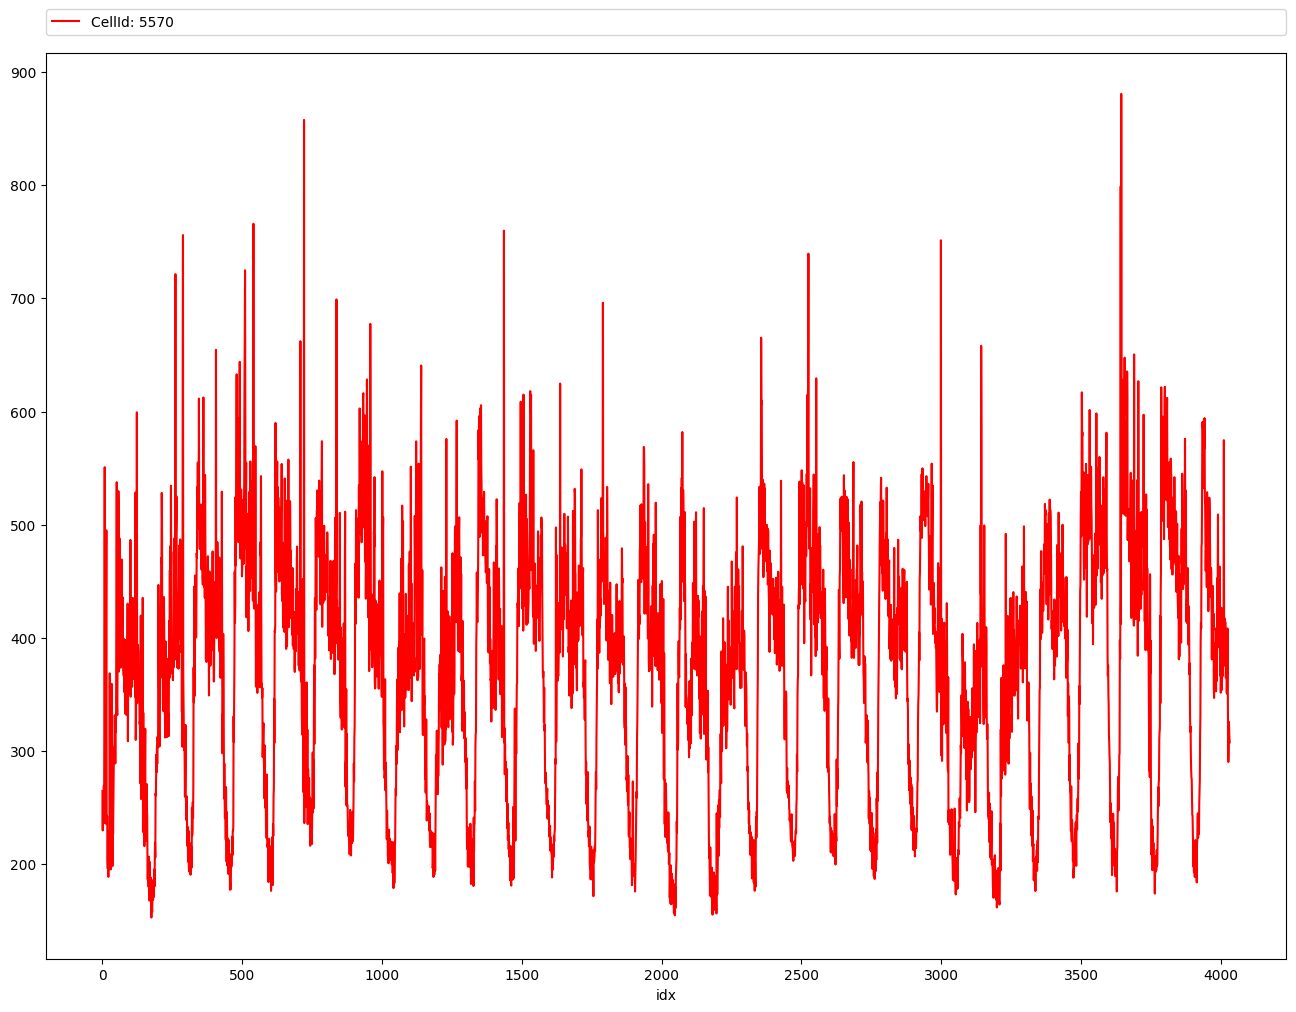

In [9]:
plt.figure(figsize=(16, 12), dpi=100) 

uni_data5570.plot(kind='line',x='index',y='internet', color='red', label = "CellId: 5570")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
plt.savefig('Prueba.png',bbox_inches='tight')

plt.show()

In [10]:
uni_data = uni_data5570

<AxesSubplot:xlabel='idx'>

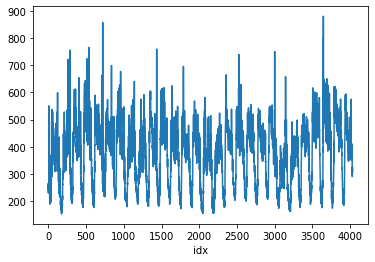

In [11]:
uni_data.plot()

In [12]:
uni_data

idx
0.0       264.667864
1.0       229.886522
2.0       260.543188
3.0       241.326109
4.0       253.345193
             ...    
4028.0    301.659528
4029.0    325.776125
4030.0    316.402061
4031.0    310.504314
4032.0    307.614187
Name: internet, Length: 4033, dtype: float64

In [13]:
uni_data = uni_data.values

In [14]:
uni_data

array([264.66786393, 229.88652229, 260.54318779, ..., 316.40206067,
       310.5043138 , 307.61418713])

In [15]:
uni_data
len(uni_data)

4033

In [16]:
from sklearn.preprocessing import MinMaxScaler
feature = ['idx', 'internet']
scaler = MinMaxScaler()
DataScaledMeteoCellId5570 = scaler.fit_transform(dataMeteoCellId5570[feature])

In [17]:
uni_data = DataScaledMeteoCellId5570

In [18]:
uni_data

array([[0.00000000e+00, 1.53608895e-01],
       [2.48015873e-04, 1.05827408e-01],
       [4.96031746e-04, 1.47942548e-01],
       ...,
       [9.99503968e-01, 2.24679669e-01],
       [9.99751984e-01, 2.16577534e-01],
       [1.00000000e+00, 2.12607171e-01]])

In [19]:
uni_data[:,1]

array([0.1536089 , 0.10582741, 0.14794255, ..., 0.22467967, 0.21657753,
       0.21260717])

In [20]:
univariate_past_history = 12
univariate_future_target = 6

x_train_uni, y_train_uni = univariate_data(uni_data[:,1], 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data[:,1], TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [21]:
len(x_train_uni)

2811

In [22]:
len(y_train_uni)

2811

In [23]:
len(x_val_uni)

1192

In [24]:
x_train_uni

array([[[0.1536089 ],
        [0.10582741],
        [0.14794255],
        ...,
        [0.13502684],
        [0.27305958],
        [0.23093229]],

       [[0.10582741],
        [0.14794255],
        [0.12154274],
        ...,
        [0.27305958],
        [0.23093229],
        [0.11394433]],

       [[0.14794255],
        [0.12154274],
        [0.13805417],
        ...,
        [0.23093229],
        [0.11394433],
        [0.37100539]],

       ...,

       [[0.45951066],
        [0.41580266],
        [0.38793576],
        ...,
        [0.36819976],
        [0.31384855],
        [0.3642017 ]],

       [[0.41580266],
        [0.38793576],
        [0.3670999 ],
        ...,
        [0.31384855],
        [0.3642017 ],
        [0.37962966]],

       [[0.38793576],
        [0.3670999 ],
        [0.36551948],
        ...,
        [0.3642017 ],
        [0.37962966],
        [0.31176572]]])

In [25]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target Internet charge to predict')
print (y_train_uni[0])

Single window of past history
[[0.1536089 ]
 [0.10582741]
 [0.14794255]
 [0.12154274]
 [0.13805417]
 [0.15982917]
 [0.11504388]
 [0.21989066]
 [0.54677916]
 [0.13502684]
 [0.27305958]
 [0.23093229]]

 Target Internet charge to predict
0.07036461035407346


In [26]:
def create_time_steps(length):
    return list(range(-length, 0))

In [27]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+3)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'D:\\Anaconda3\\envs\\gputensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

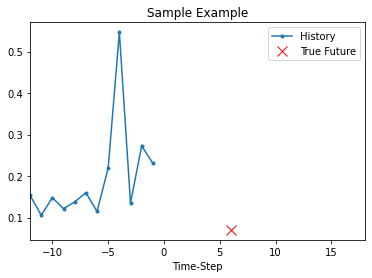

In [28]:
show_plot([x_train_uni[0], y_train_uni[0]], 6, 'Sample Example')

<module 'matplotlib.pyplot' from 'D:\\Anaconda3\\envs\\gputensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

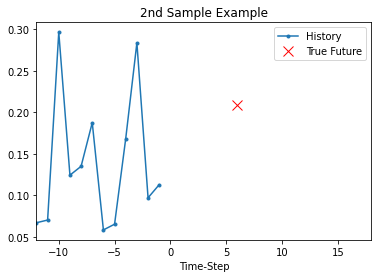

In [29]:
show_plot([x_train_uni[24], y_train_uni[24]], 6, '2nd Sample Example')

# Recurrent neural network con cambio de variables con la CellId 5570 -LSTM

In [30]:
EPOCHS = [50]
BATCH_SIZE = [64]
NODOS = [64]
LAYERS = [4]
LEARNINGRATE = [0.001]

i = 1
model5570ArrayAcc = []
model5570mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_lstm_s = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm_s.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm_s.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm_s.add(tf.keras.layers.LSTM(nodo))
                else :
                    simple_lstm_s.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm_s.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                    simple_lstm_s.add(tf.keras.layers.LSTM(nodo))
                simple_lstm_s.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm_s.summary()

                simple_lstm_s.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

                history_lstm_s = simple_lstm_s.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=1)
                
                score = simple_lstm_s.evaluate(x_train_uni, y_train_uni, verbose=1)
                model5570ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], score[0], score[1]])
                
                test_predictions_lstm_s = simple_lstm_s.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions_lstm_s).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions_lstm_s).numpy()
                model5570mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 50batch: 64nodos: 64layer: 4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 64)            33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
44/44 [==============================] - 3s 71ms/step - loss: 0.0286

In [31]:
test_predictions_lstm_s

array([[0.3442294 ],
       [0.3474641 ],
       [0.32615036],
       ...,
       [0.27864248],
       [0.29848003],
       [0.29433137]], dtype=float32)

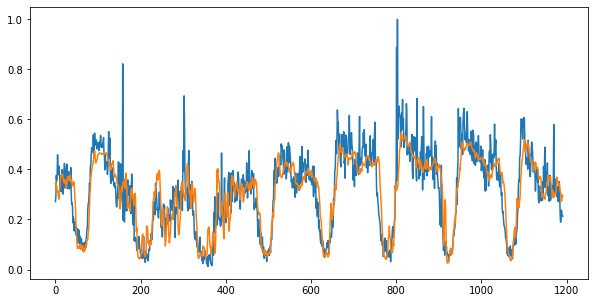

In [32]:
plt.figure(figsize=(10,5))
plt.plot(y_val_uni)
plt.plot(test_predictions_lstm_s)
plt.show()

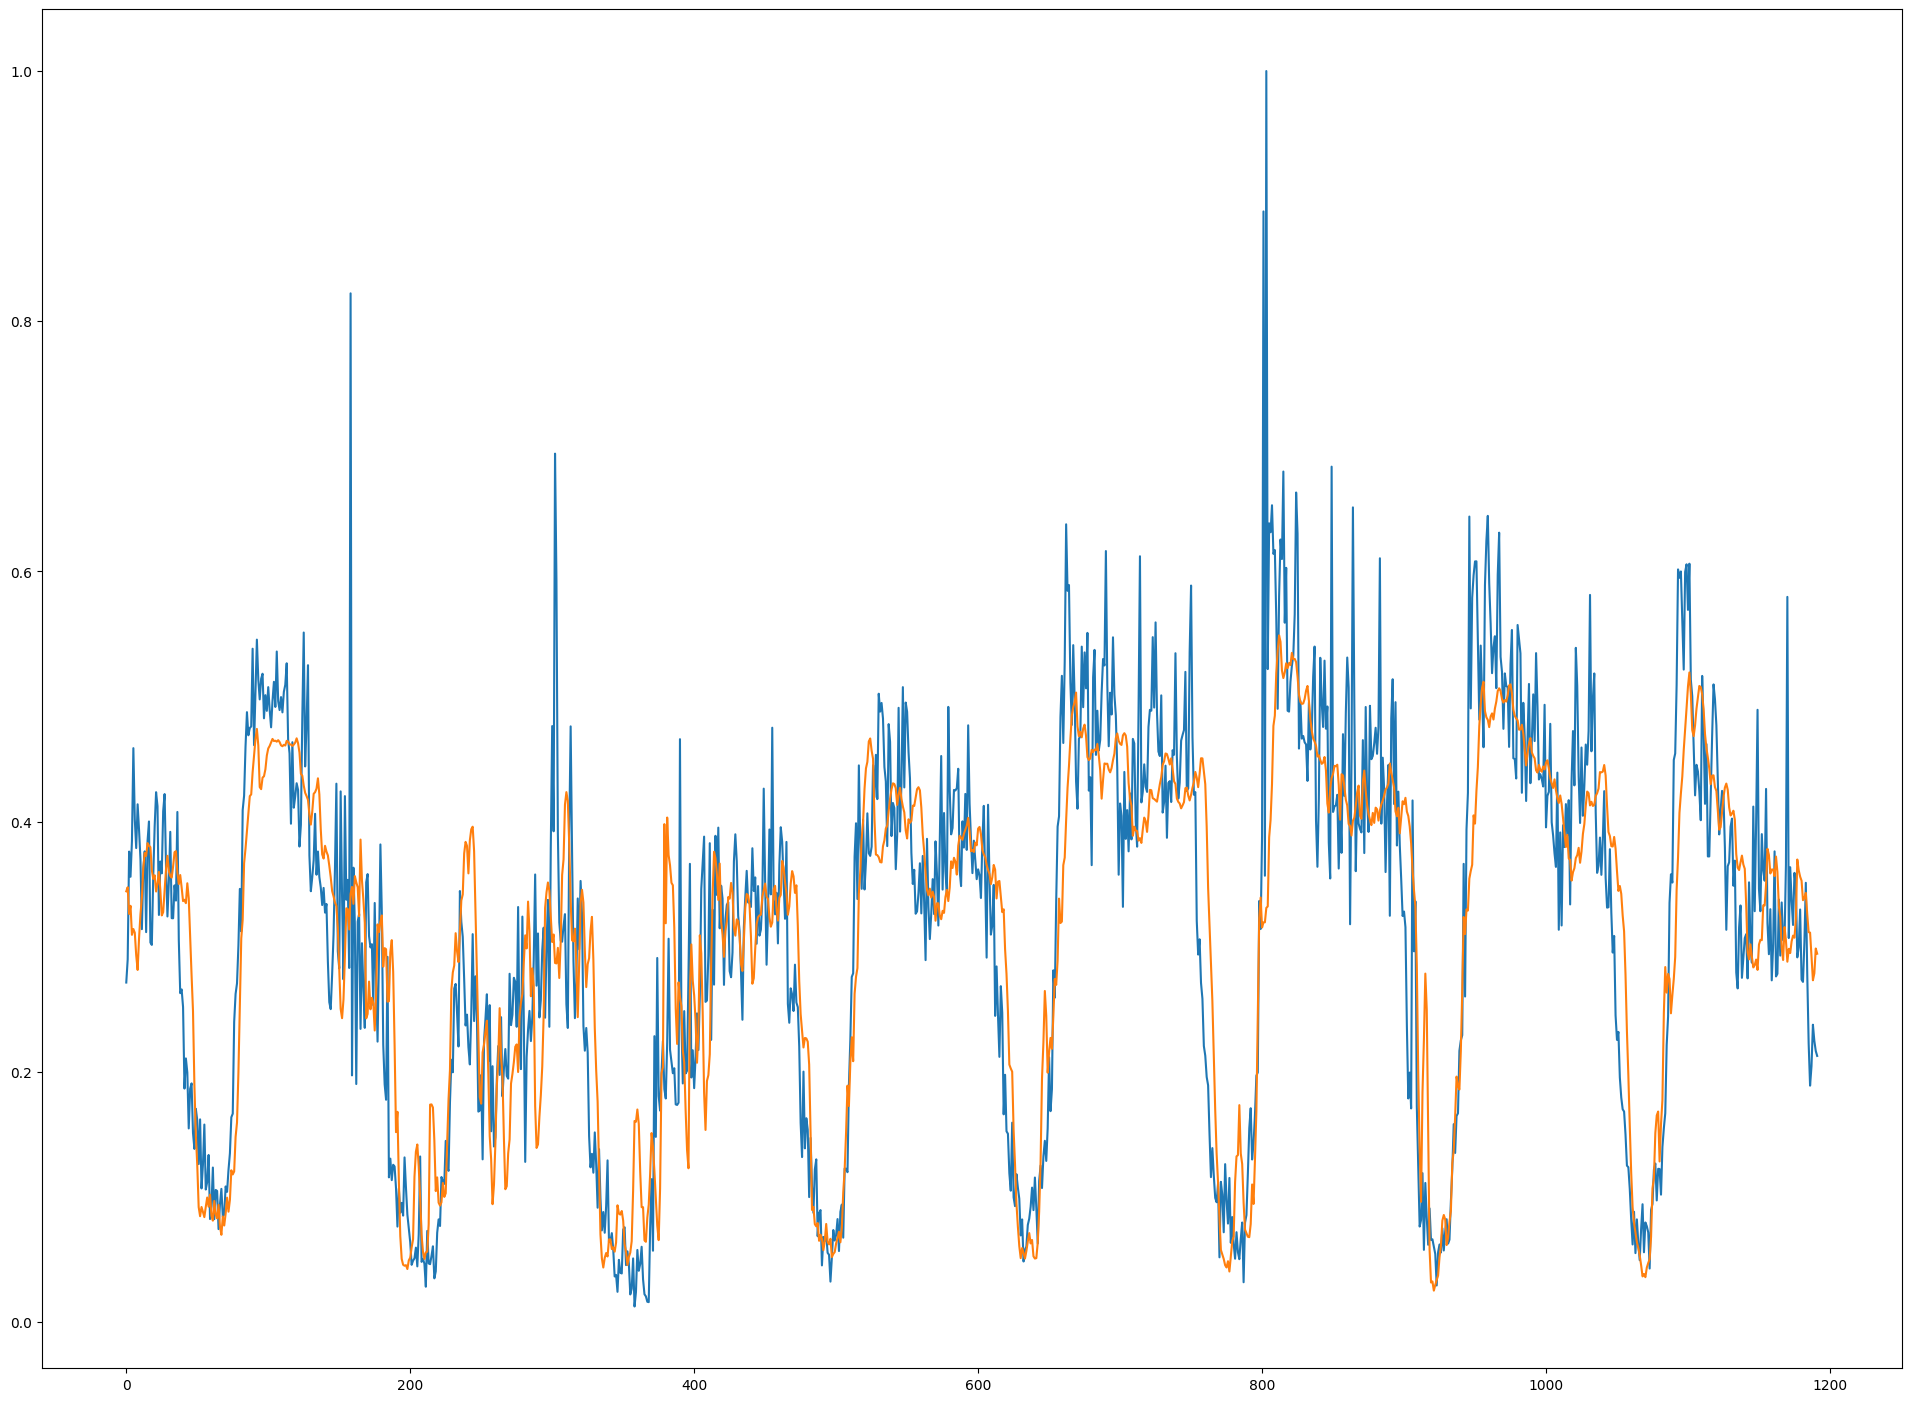

In [33]:
plt.figure(figsize=(24, 18), dpi=100) 
plt.plot(y_val_uni)
plt.plot(test_predictions_lstm_s)
plt.savefig('transformed_data/images/BEST-5570-12-0-6-LSTM.png',bbox_inches='tight')
plt.show()

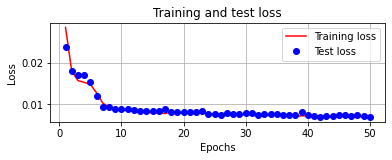

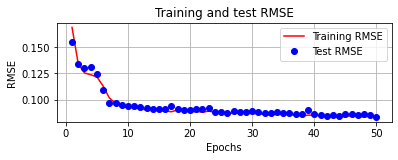

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_lstm_s.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
rmse_values = history_dict['root_mean_squared_error']
val_rmse_values = history_dict['val_root_mean_squared_error']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_lstm_s.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_lstm_s.history['root_mean_squared_error'], 'r', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'bo', label='Test RMSE')
plt.title('Training and test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') 
plt.legend()
plt.grid('off')
plt.savefig('transformed_data/images/BEST-5570-12-0-6-LSTM_Loss_RMSE.png',bbox_inches='tight')
plt.show()

In [35]:
print (dmse)

0.043523062


In [36]:
print (drmse)

0.08373535


# Recurrent neural network con cambio de variables con la CellId 5570 - GRU

In [37]:
EPOCHS = [100]
BATCH_SIZE = [64]
NODOS = [32]
LAYERS = [8]
LEARNINGRATE = [0.0005]

i = 1
model5570ArrayAcc = []
model5570mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_gru_s = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_gru_s.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_gru_s.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_gru_s.add(tf.keras.layers.GRU(nodo))
                else :
                    simple_gru_s.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_gru_s.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                    simple_gru_s.add(tf.keras.layers.GRU(nodo))
                simple_gru_s.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_gru_s.summary()

                simple_gru_s.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

                history_gru_s = simple_gru_s.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=1)
                
                score = simple_gru_s.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5570ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], score[0], score[1]])
                
                test_predictions_gru_s = simple_gru_s.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions_gru_s).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions_gru_s).numpy()
                model5570mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 100batch: 64nodos: 32layer: 8
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 12, 32)            3360      
_________________________________________________________________
gru_1 (GRU)                  (None, 12, 32)            6336      
_________________________________________________________________
gru_2 (GRU)                  (None, 12, 32)            6336      
_________________________________________________________________
gru_3 (GRU)                  (None, 12, 32)            6336      
_________________________________________________________________
gru_4 (GRU)                  (None, 12, 32)            6336      
_________________________________________________________________
gru_5 (GRU)                  (None, 12, 32)            6336      
_________________________________________________________________
gru_6 (GRU)     

In [38]:
test_predictions_gru_s

array([[0.33038527],
       [0.3301252 ],
       [0.31768298],
       ...,
       [0.31256056],
       [0.3110562 ],
       [0.31038836]], dtype=float32)

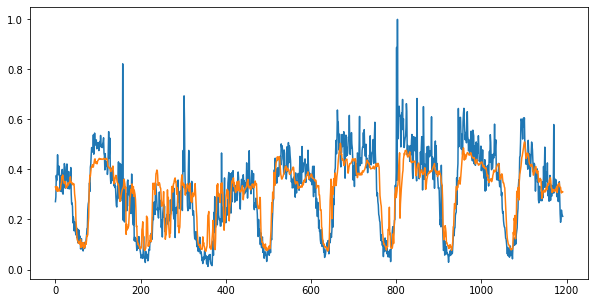

In [39]:
plt.figure(figsize=(10,5))
plt.plot(y_val_uni)
plt.plot(test_predictions_gru_s)
plt.show()

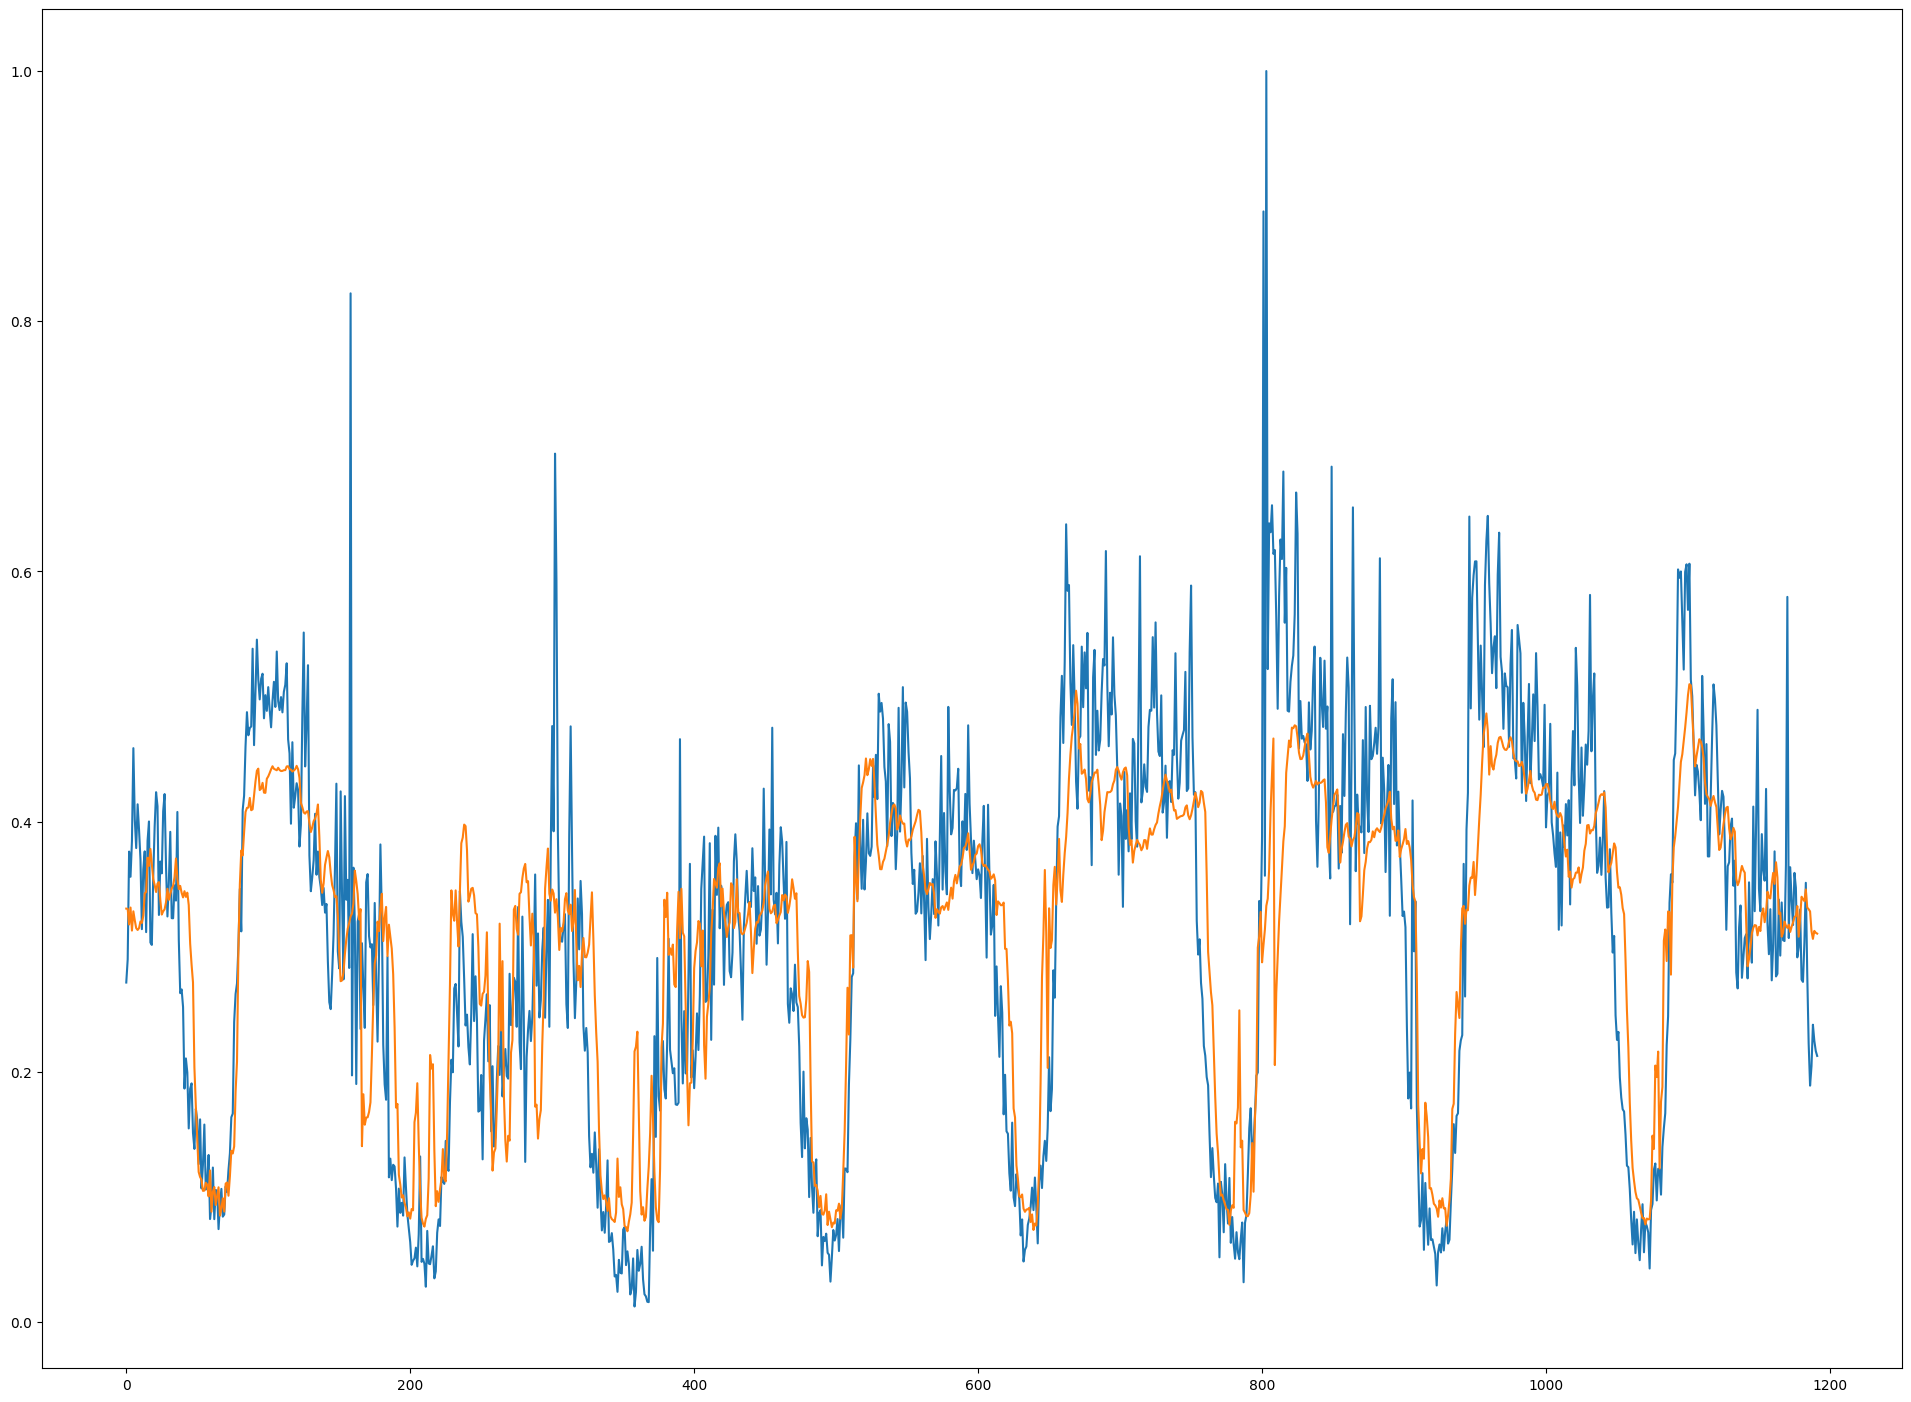

In [40]:
plt.figure(figsize=(24, 18), dpi=100) 
plt.plot(y_val_uni)
plt.plot(test_predictions_gru_s)
plt.savefig('transformed_data/images/BEST-5570-12-0-6_GRU.png',bbox_inches='tight')
plt.show()

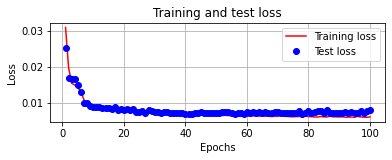

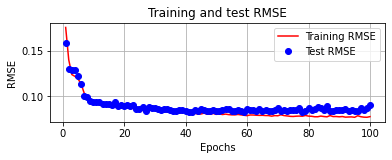

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_gru_s.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
rmse_values = history_dict['root_mean_squared_error']
val_rmse_values = history_dict['val_root_mean_squared_error']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_gru_s.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_gru_s.history['root_mean_squared_error'], 'r', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'bo', label='Test RMSE')
plt.title('Training and test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') 
plt.legend()
plt.grid('off')
plt.savefig('transformed_data/images/BEST-5570-12-0-6_GRU_Loss_RMSE.png',bbox_inches='tight')
plt.show()

In [42]:
print (dmse)

0.03858537


In [43]:
print (drmse)

0.09009073


# Conjunto LSTM y GRU

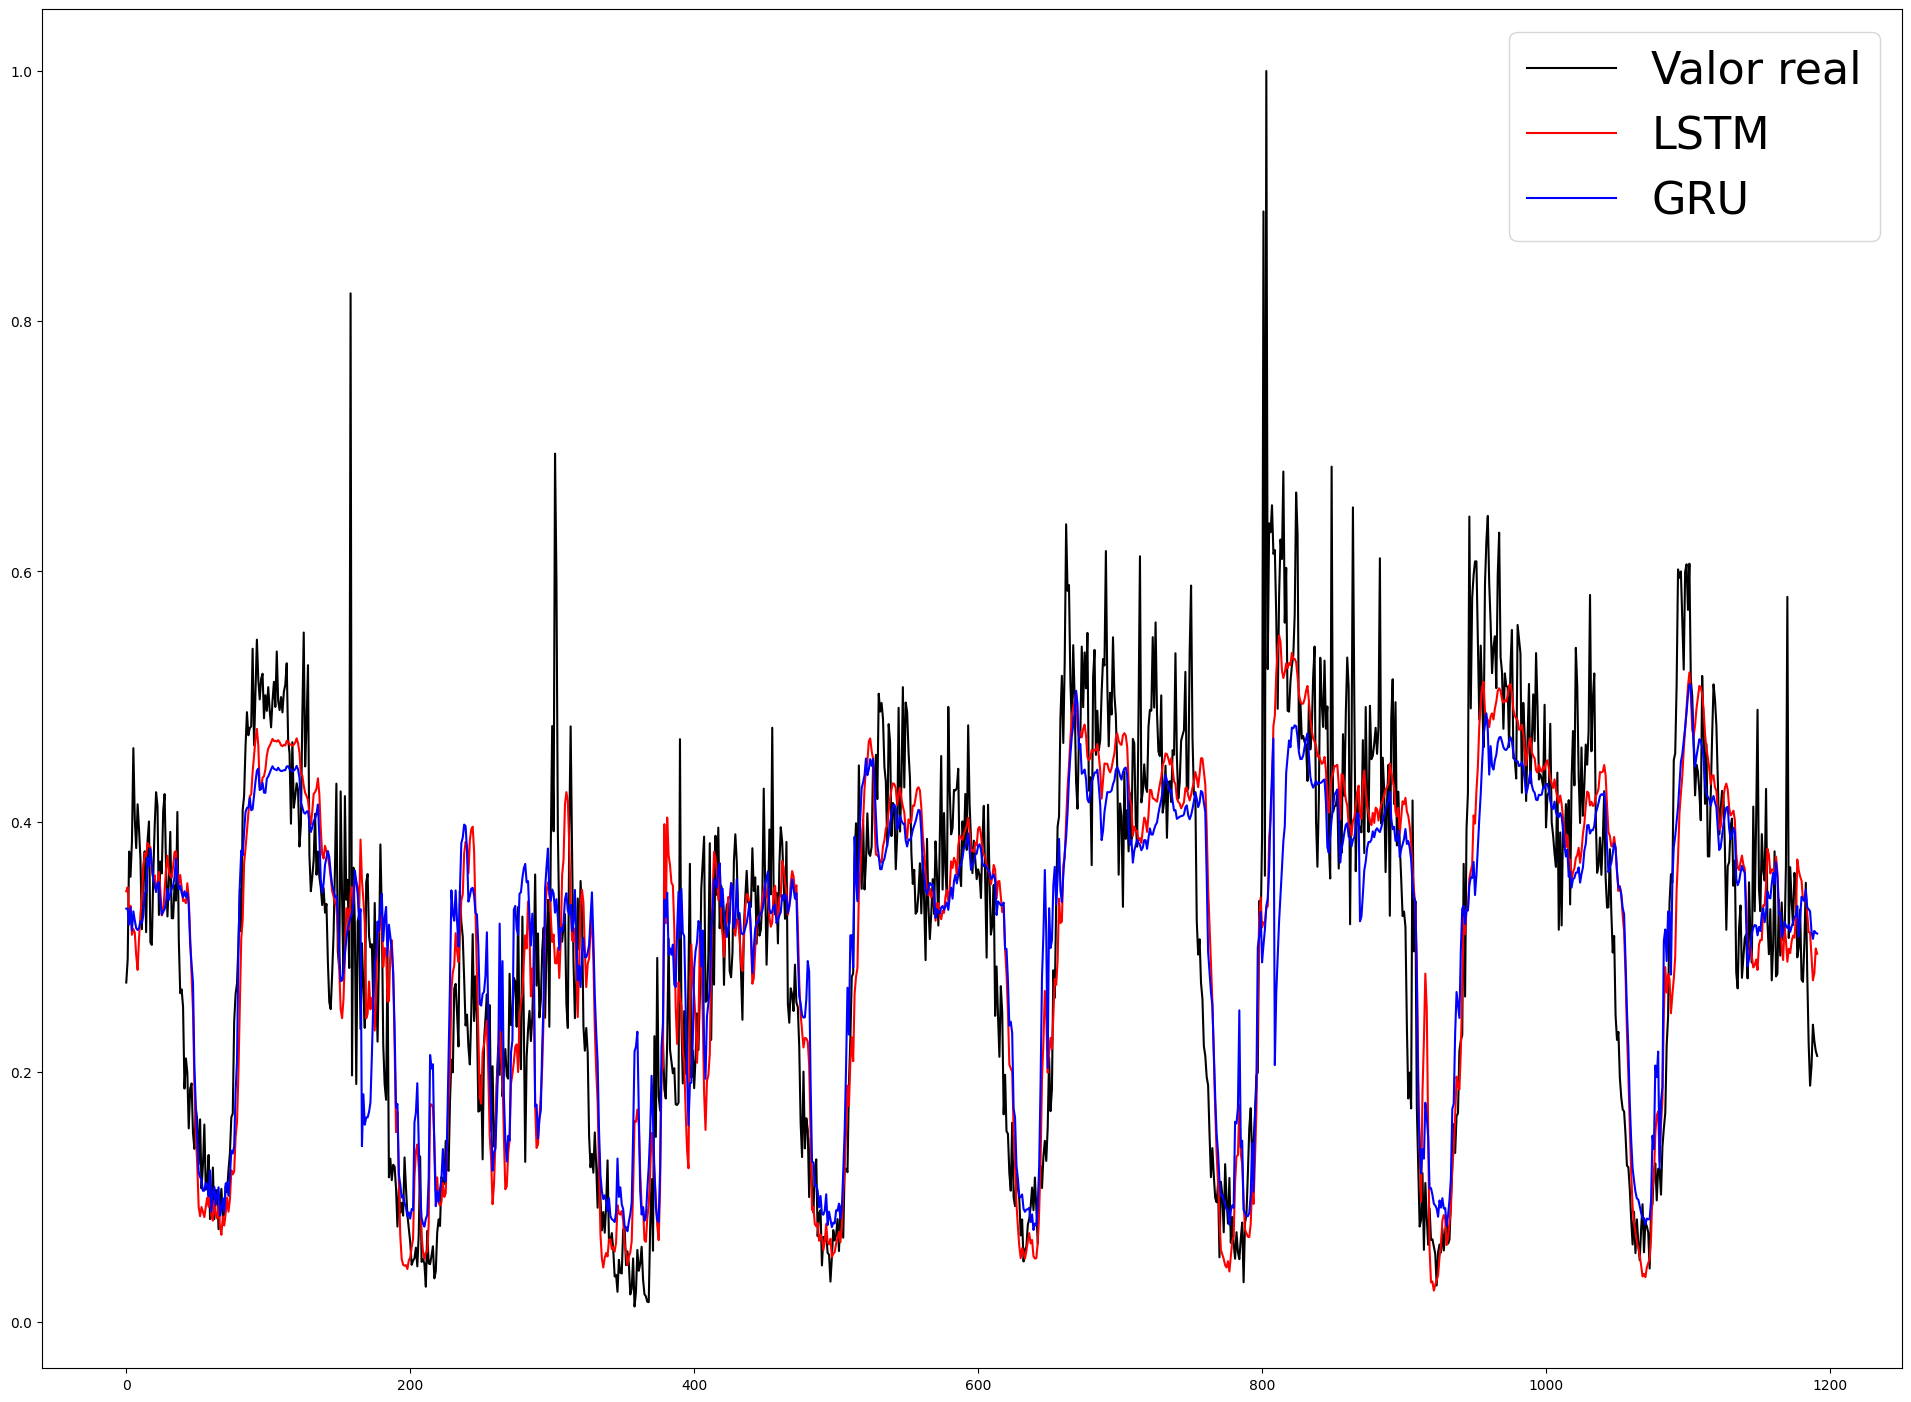

In [44]:
plt.figure(figsize=(24, 18), dpi=100) 
real, = plt.plot(y_val_uni, color='k')
glstm, = plt.plot(test_predictions_lstm_s, color='r')
ggru, = plt.plot(test_predictions_gru_s, color='b')

plt.legend([real, glstm, ggru], ["Valor real", "LSTM", "GRU"], prop={'size': 32})

plt.savefig('transformed_data/images/5570-12-0-6_LSTM_GRU_COMB.png',bbox_inches='tight')
plt.show()

# Recurrent neural network con cambio de variables con la CellId 5570 multivariate time series

In [45]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet']

In [46]:
multi_data5570 = dataMeteoCellId5570[features_considered]
multi_data5570.index = dataMeteoCellId5570['idx'] - 47088.0
multi_data5570.head()

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                     
0.0     9.900000              88.0            0.0       1.00  264.667864
1.0     9.916667              88.0            0.0       0.95  229.886522
2.0     9.933333              88.0            0.0       0.90  260.543188
3.0     9.950000              88.0            0.0       0.85  241.326109
4.0     9.966667              88.0            0.0       0.80  253.345193

In [47]:
len(multi_data5570)

4033

In [48]:
dataset = multi_data5570.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

<Figure size 2400x1800 with 0 Axes>

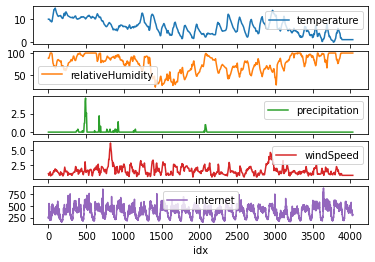

In [49]:
plt.figure(figsize=(24, 18), dpi=100) 
multi_data5570.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba1.png',bbox_inches='tight')
plt.show()

In [50]:
multi_data5570

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                        
0.0        9.900000              88.0            0.0       1.00  264.667864
1.0        9.916667              88.0            0.0       0.95  229.886522
2.0        9.933333              88.0            0.0       0.90  260.543188
3.0        9.950000              88.0            0.0       0.85  241.326109
4.0        9.966667              88.0            0.0       0.80  253.345193
...             ...               ...            ...        ...         ...
4028.0     0.900000             100.0            0.0       0.70  301.659528
4029.0     0.900000             100.0            0.0       0.70  325.776125
4030.0     0.900000             100.0            0.0       0.70  316.402061
4031.0     0.900000             100.0            0.0       0.70  310.504314
4032.0     0.900000             100.0            0.0       0.70  307.614187

[4033 rows x 5 columns]

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5570 = scaler.fit_transform(multi_data5570)

In [52]:
dataset = DataScaledMeteoCellId5570

In [53]:
dataset

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414, 0.22467967],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21657753],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21260717]])

In [54]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [55]:
dataset[:, 4]

array([0.1536089 , 0.10582741, 0.14794255, ..., 0.22467967, 0.21657753,
       0.21260717])

In [56]:
dataset

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414, 0.22467967],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21657753],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21260717]])

In [57]:
#univariate_past_history = 12
#univariate_future_target = 6
past_history = 12
future_target = 6
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [58]:
x_train_multi[0]

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       [0.67666667, 0.84615385, 0.        , 0.07758621, 0.12154274],
       [0.67777778, 0.84615385, 0.        , 0.06896552, 0.13805417],
       [0.67888889, 0.84615385, 0.        , 0.06034483, 0.15982917],
       [0.68      , 0.84615385, 0.        , 0.05172414, 0.11504388],
       [0.67777778, 0.85470085, 0.        , 0.05747126, 0.21989066],
       [0.67555556, 0.86324786, 0.        , 0.06321839, 0.54677916],
       [0.67333333, 0.87179487, 0.        , 0.06896552, 0.13502684],
       [0.67111111, 0.88034188, 0.        , 0.07471264, 0.27305958],
       [0.66888889, 0.88888889, 0.        , 0.08045977, 0.23093229]])

In [59]:
y_train_multi[0]

0.07036461035407346

In [60]:
EPOCHS = [50]
BATCH_SIZE = [64]
NODOS = [32]
LAYERS = [4]
LEARNINGRATE = [0.001]

i = 1
model5570ArrayAcc = []
model5570mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_lstm_m = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm_m.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm_m.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm_m.add(tf.keras.layers.LSTM(nodo))
                else :
                    simple_lstm_m.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm_m.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                    simple_lstm_m.add(tf.keras.layers.LSTM(nodo))
                simple_lstm_m.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm_m.summary()

                simple_lstm_m.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

                history_lstm_m = simple_lstm_m.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=1)
                
                score = simple_lstm_m.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5570ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], score[0], score[1]])
                
                test_predictions_lstm_m = simple_lstm_m.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions_lstm_m).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions_lstm_m).numpy()
                model5570mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 50batch: 64nodos: 32layer: 4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 12, 32)            4352      
_________________________________________________________________
lstm_5 (LSTM)                (None, 12, 32)            8320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 12, 32)            8320      
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
44/44 [==============================] - 3s 62ms/step - loss: 0.0300

In [61]:
test_predictions_lstm_m

array([[0.35026297],
       [0.35188988],
       [0.32844177],
       ...,
       [0.28368556],
       [0.30655083],
       [0.29961026]], dtype=float32)

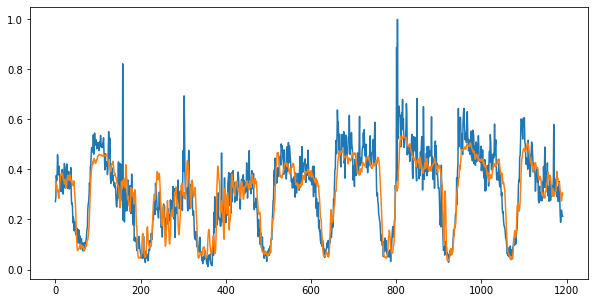

In [62]:
plt.figure(figsize=(10,5))
plt.plot(y_val_uni)
plt.plot(test_predictions_lstm_m)
plt.show()

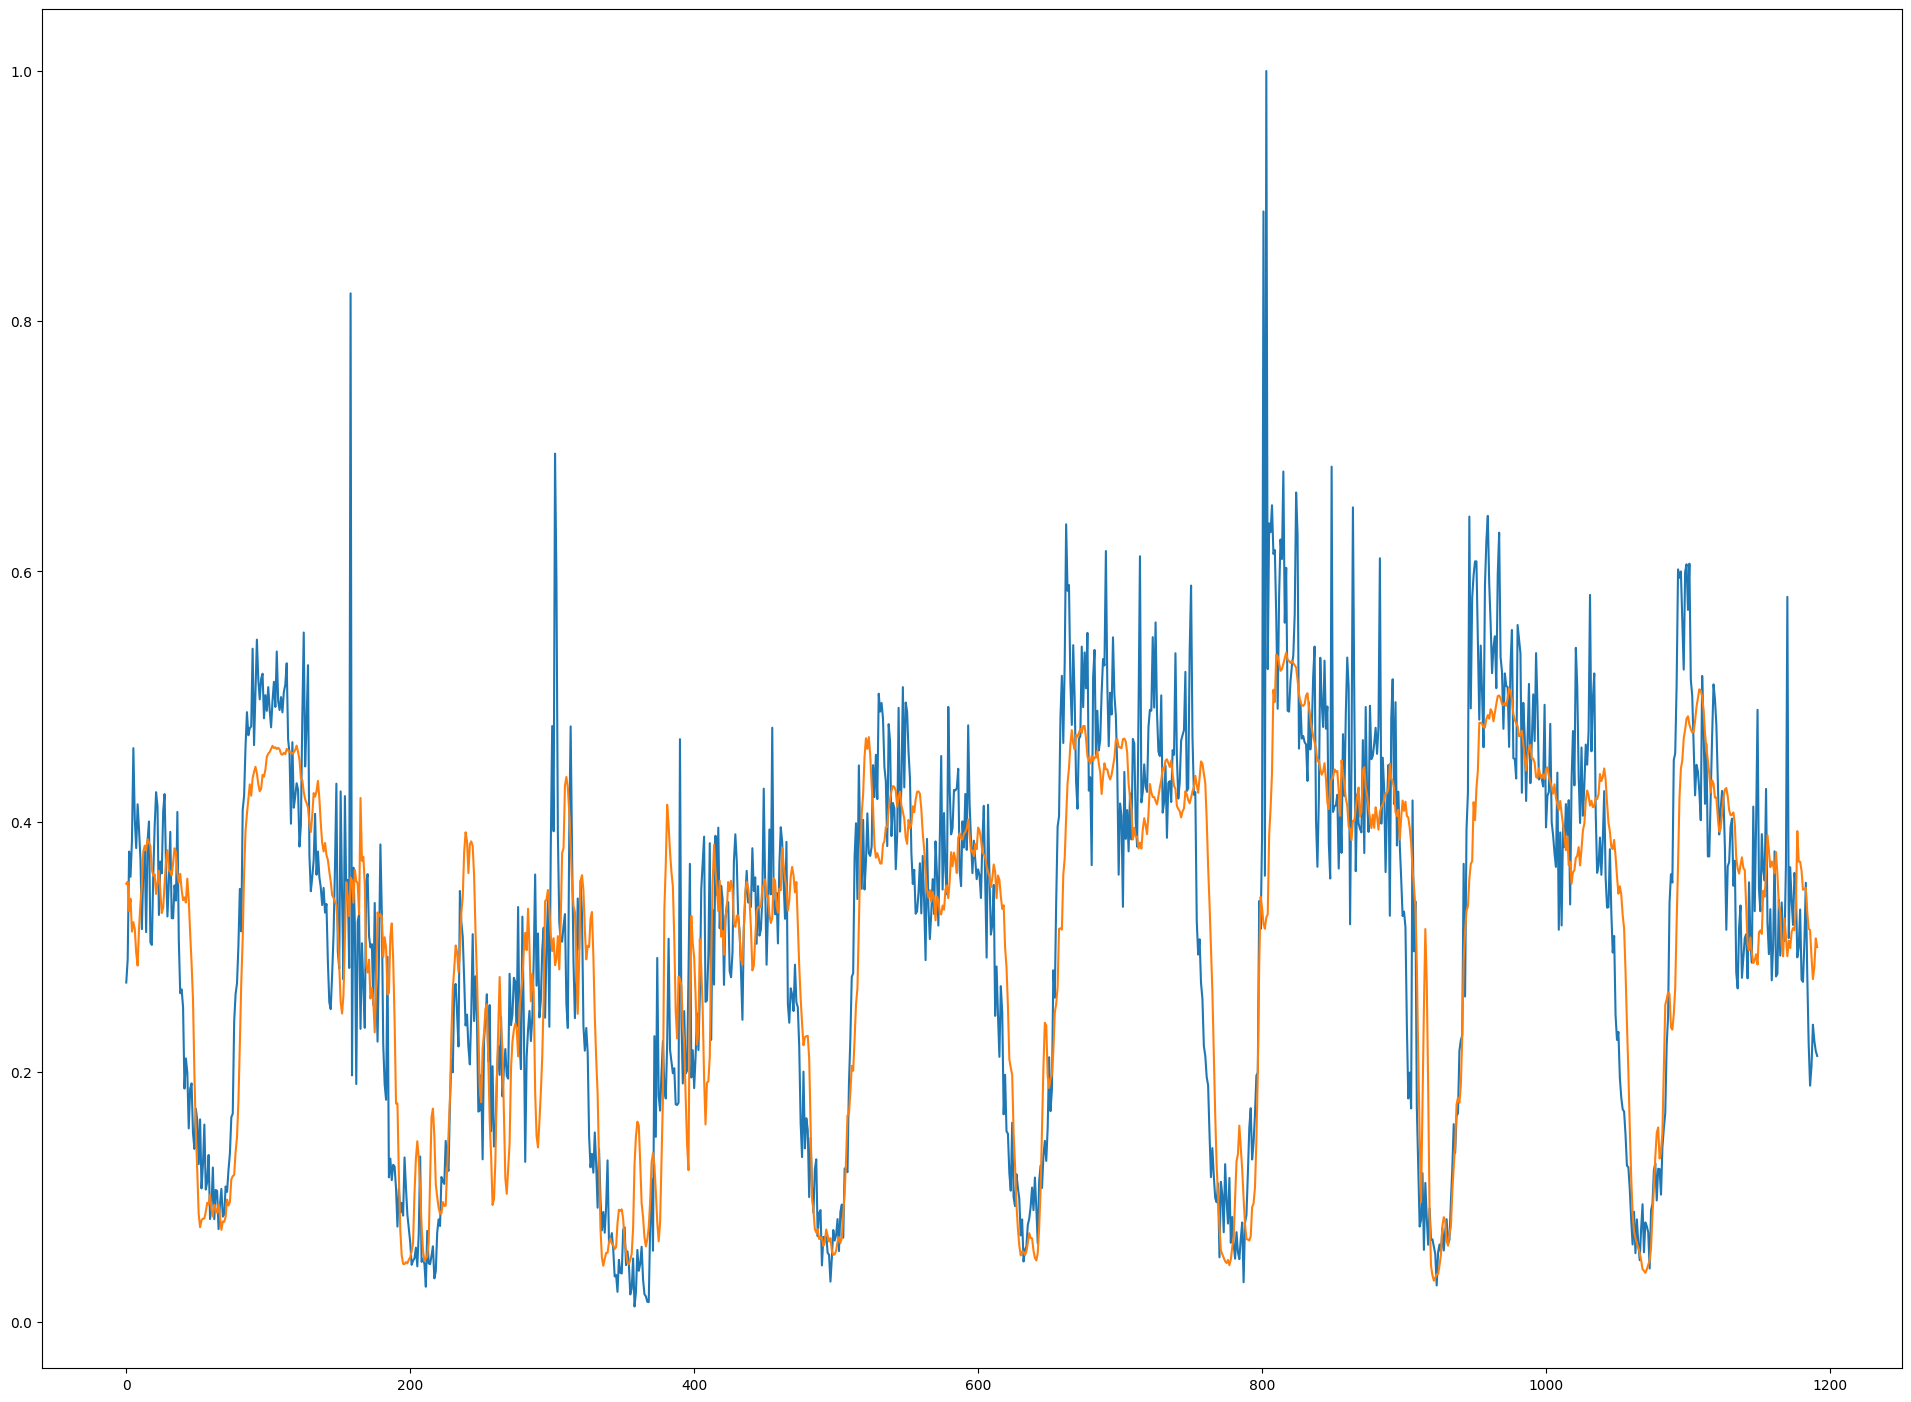

In [63]:
plt.figure(figsize=(24, 18), dpi=100) 
plt.plot(y_val_uni)
plt.plot(test_predictions_lstm_m)
plt.savefig('transformed_data/images/BEST-5570-12-0-6-TRPW-LSTM.png',bbox_inches='tight')
plt.show()

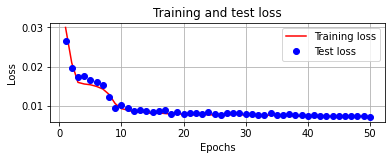

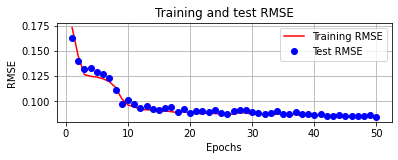

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_lstm_m.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
rmse_values = history_dict['root_mean_squared_error']
val_rmse_values = history_dict['val_root_mean_squared_error']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_lstm_m.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_lstm_m.history['root_mean_squared_error'], 'r', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'bo', label='Test RMSE')
plt.title('Training and test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') 
plt.legend()
plt.grid('off')
plt.savefig('transformed_data/images/BEST-5570-12-0-6-TRPW-LSTM_Loss_RMSE.png',bbox_inches='tight')
plt.show()

In [65]:
print (dmse)

0.04358135


In [66]:
print (drmse)

0.084468916


# Recurrent neural network con cambio de hiperparametros con la CellId 5570 multivariate time series - GRU

In [67]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet']

In [68]:
multi_data5570 = dataMeteoCellId5570[features_considered]
multi_data5570.index = dataMeteoCellId5570['idx'] - 47088.0
multi_data5570.head()

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                     
0.0     9.900000              88.0            0.0       1.00  264.667864
1.0     9.916667              88.0            0.0       0.95  229.886522
2.0     9.933333              88.0            0.0       0.90  260.543188
3.0     9.950000              88.0            0.0       0.85  241.326109
4.0     9.966667              88.0            0.0       0.80  253.345193

In [69]:
len(multi_data5570)

4033

In [70]:
multi_data5570

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                        
0.0        9.900000              88.0            0.0       1.00  264.667864
1.0        9.916667              88.0            0.0       0.95  229.886522
2.0        9.933333              88.0            0.0       0.90  260.543188
3.0        9.950000              88.0            0.0       0.85  241.326109
4.0        9.966667              88.0            0.0       0.80  253.345193
...             ...               ...            ...        ...         ...
4028.0     0.900000             100.0            0.0       0.70  301.659528
4029.0     0.900000             100.0            0.0       0.70  325.776125
4030.0     0.900000             100.0            0.0       0.70  316.402061
4031.0     0.900000             100.0            0.0       0.70  310.504314
4032.0     0.900000             100.0            0.0       0.70  307.614187

[4033 rows x 5 columns]

In [71]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5570 = scaler.fit_transform(multi_data5570)

In [72]:
dataset = DataScaledMeteoCellId5570

In [73]:
dataset

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414, 0.22467967],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21657753],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21260717]])

In [74]:
len(dataset)

4033

In [75]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [76]:
dataset[:, 4]

array([0.1536089 , 0.10582741, 0.14794255, ..., 0.22467967, 0.21657753,
       0.21260717])

In [77]:
dataset #dataset[:, [0,1,2,3]]

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414, 0.22467967],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21657753],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21260717]])

In [78]:
#univariate_past_history = 12
#univariate_future_target = 6
past_history = 12
future_target = 6
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [79]:
len(x_train_multi)

2811

In [80]:
len(x_val_multi)

1192

In [81]:
EPOCHS = [75]
BATCH_SIZE = [256] #128
NODOS = [32] #64
LAYERS = [8]
LEARNINGRATE = [0.001]

i = 1
model5570ArrayAcc = []
model5570mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_gru_m = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_gru_m.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_gru_m.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_gru_m.add(tf.keras.layers.GRU(nodo))
                else :
                    simple_gru_m.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_gru_m.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                    simple_gru_m.add(tf.keras.layers.GRU(nodo))
                simple_gru_m.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_gru_m.summary()

                simple_gru_m.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

                history_gru_m = simple_gru_m.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=1)
                
                score = simple_gru_m.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5570ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], score[0], score[1]])
                
                test_predictions_gru_m = simple_gru_m.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions_gru_m).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions_gru_m).numpy()
                model5570mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 75batch: 256nodos: 32layer: 8
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 12, 32)            3360      
_________________________________________________________________
gru_9 (GRU)                  (None, 12, 32)            6336      
_________________________________________________________________
gru_10 (GRU)                 (None, 12, 32)            6336      
_________________________________________________________________
gru_11 (GRU)                 (None, 12, 32)            6336      
_________________________________________________________________
gru_12 (GRU)                 (None, 12, 32)            6336      
_________________________________________________________________
gru_13 (GRU)                 (None, 12, 32)            6336      
_________________________________________________________________
gru_14 (GRU)    

In [82]:
test_predictions_gru_m

array([[0.3418225 ],
       [0.34053117],
       [0.3156689 ],
       ...,
       [0.28476554],
       [0.29553548],
       [0.28826284]], dtype=float32)

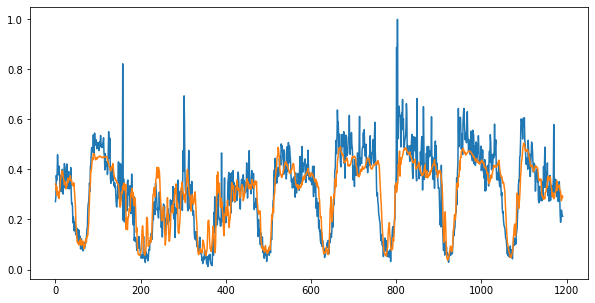

In [83]:
plt.figure(figsize=(10,5))
plt.plot(y_val_uni)
plt.plot(test_predictions_gru_m)
plt.show()

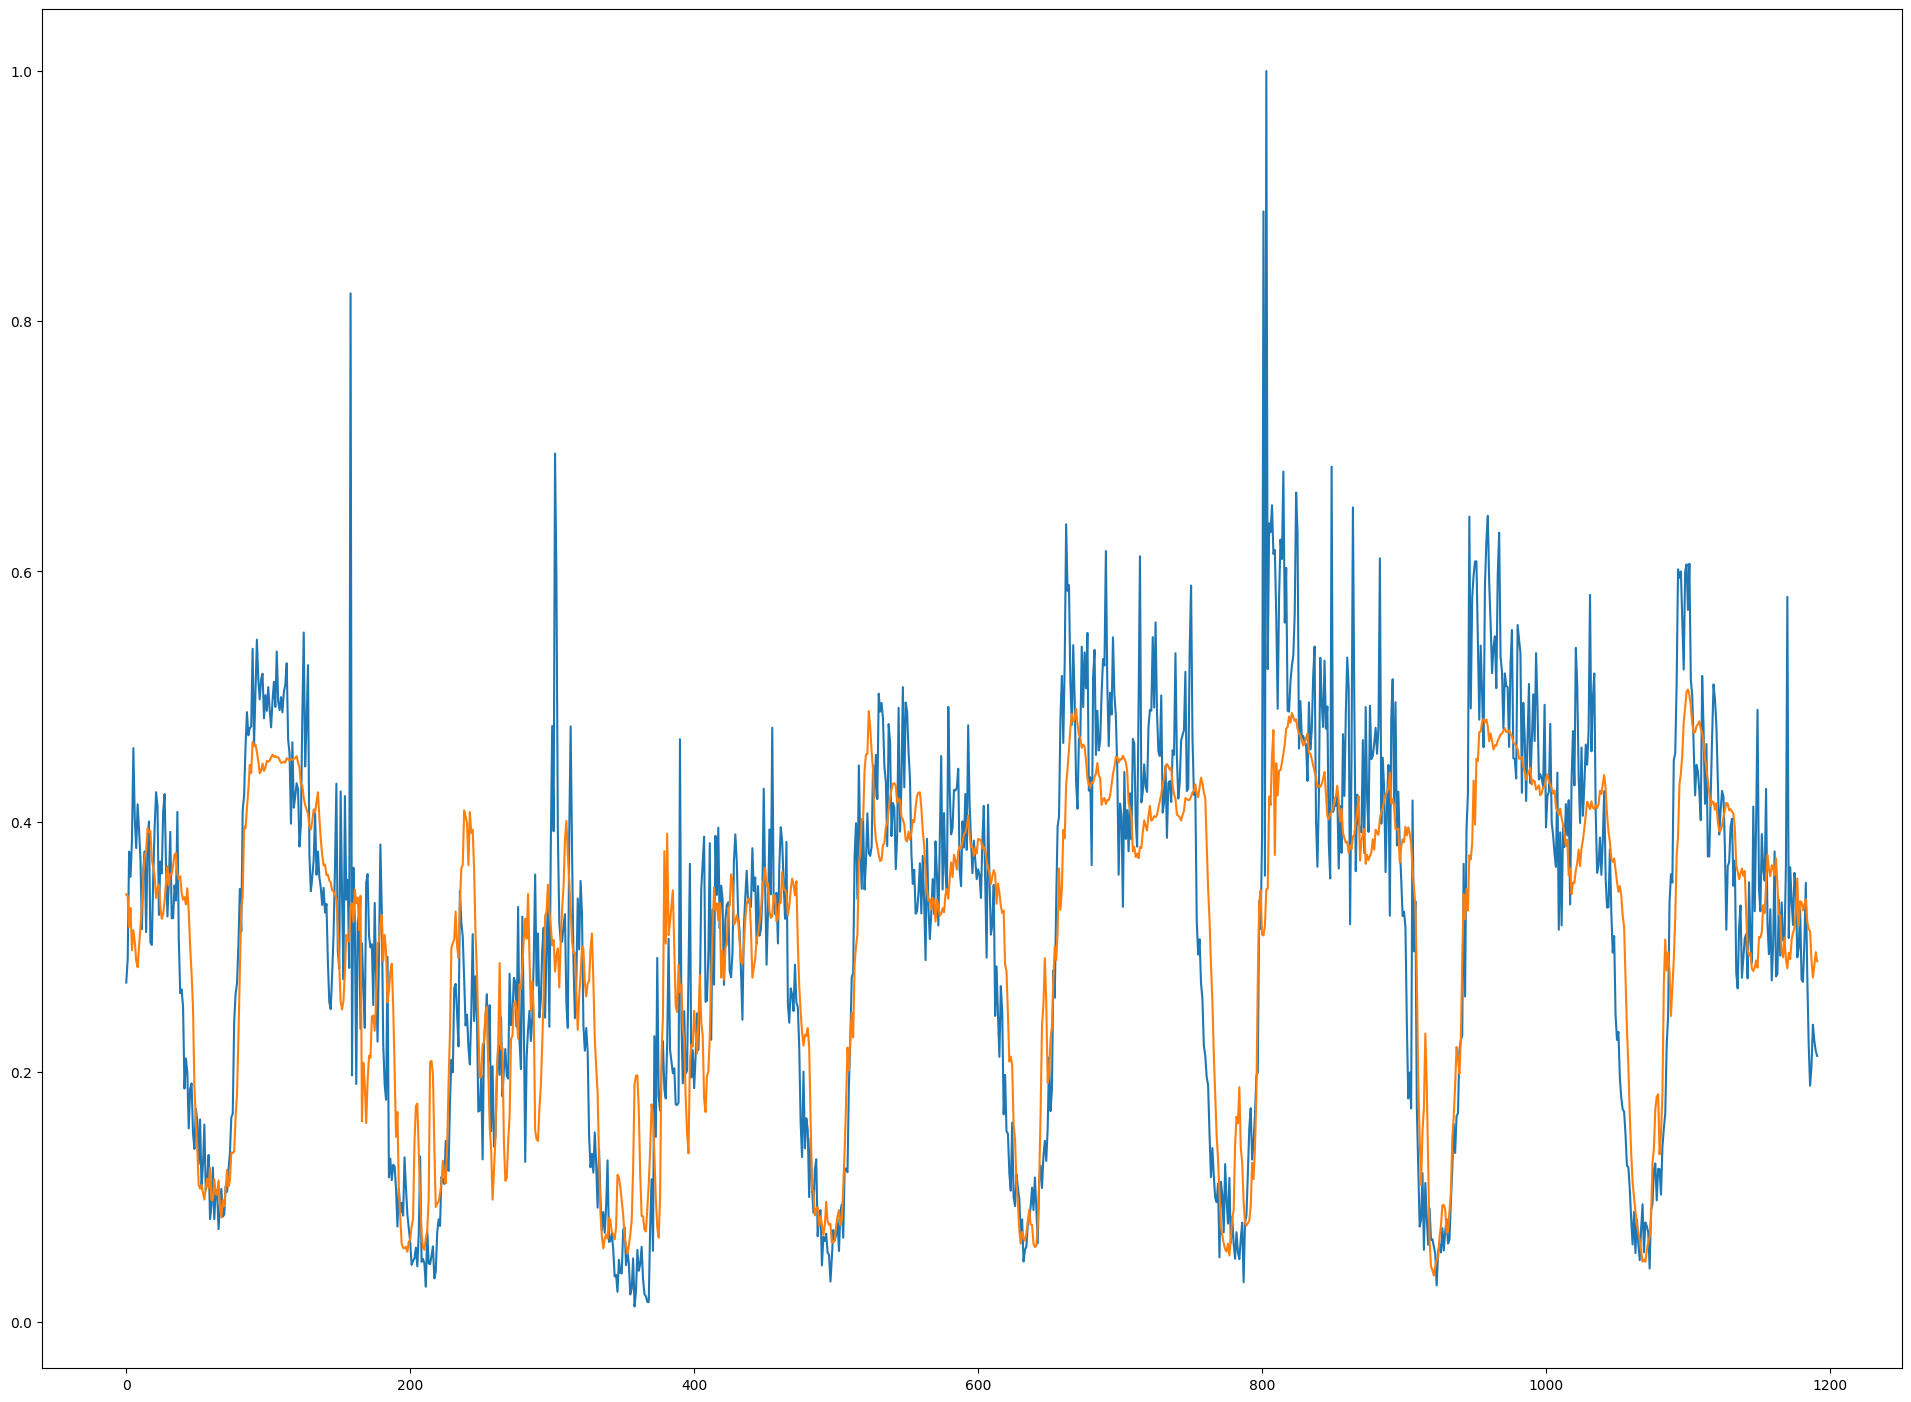

In [84]:
plt.figure(figsize=(24, 18), dpi=100) 
plt.plot(y_val_uni)
plt.plot(test_predictions_gru_m)
plt.savefig('transformed_data/images/BEST-5570-12-0-6-TRPW-GRU.png',bbox_inches='tight')
plt.show()

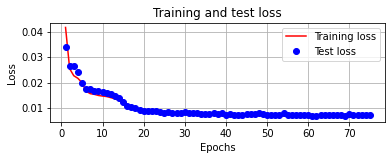

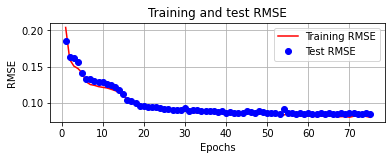

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_gru_m.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
rmse_values = history_dict['root_mean_squared_error']
val_rmse_values = history_dict['val_root_mean_squared_error']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_gru_m.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_gru_m.history['root_mean_squared_error'], 'r', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'bo', label='Test RMSE')
plt.title('Training and test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') 
plt.legend()
plt.grid('off')
plt.savefig('transformed_data/images/BEST-5570-12-0-6-TRPW-GRU_Loss_RMSE.png',bbox_inches='tight')
plt.show()

In [86]:
print (dmse)

0.040987045


In [87]:
print (drmse)

0.084442854


# Conjunto LSTM y GRU

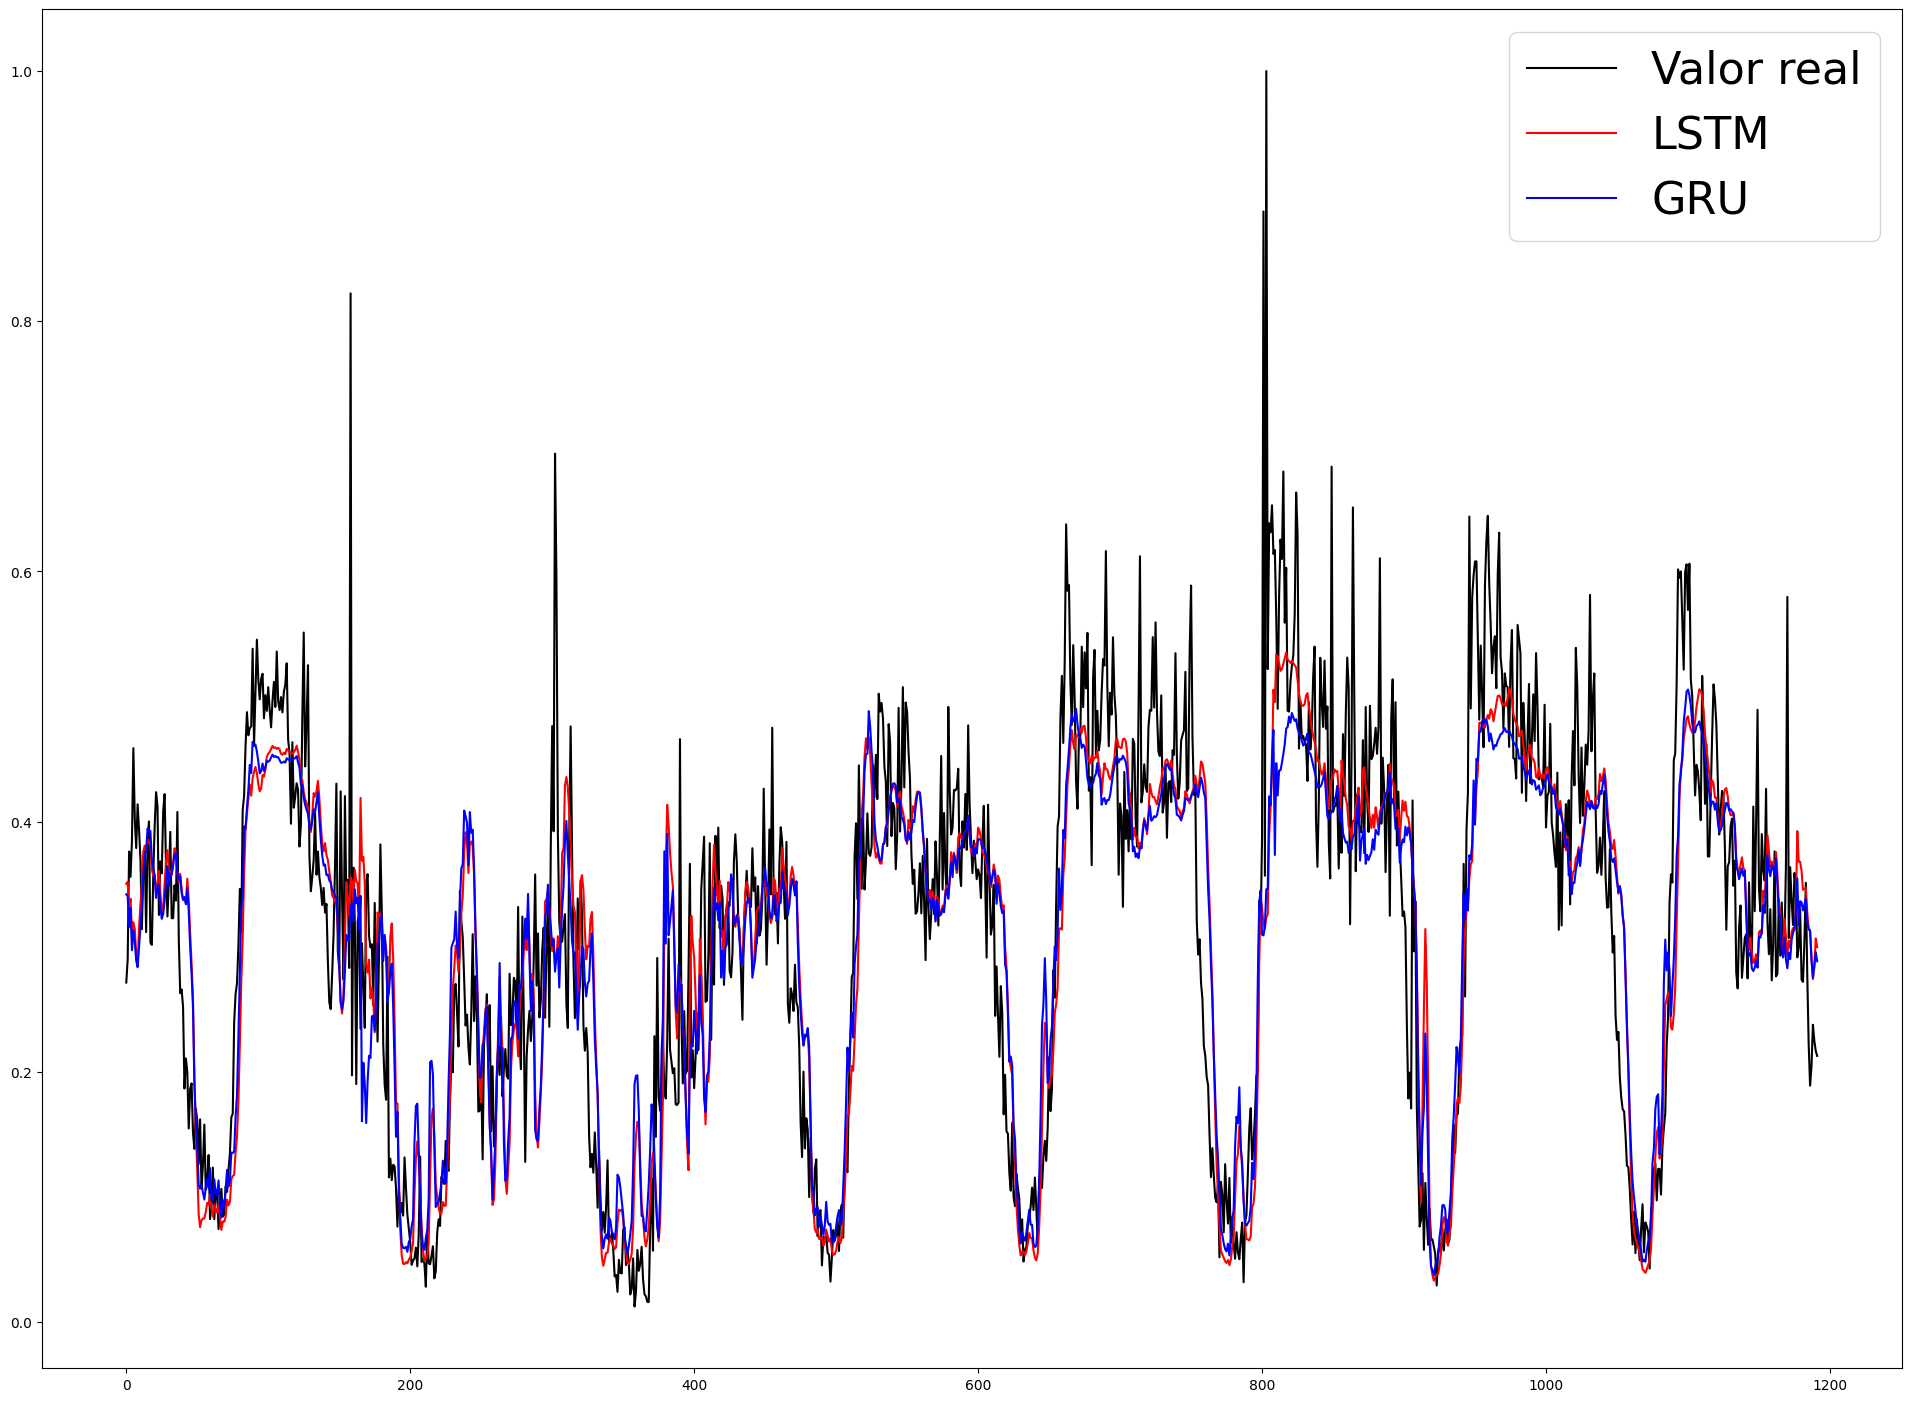

In [88]:
plt.figure(figsize=(24, 18), dpi=100) 
real, = plt.plot(y_val_uni, color='k')
glstm, = plt.plot(test_predictions_lstm_m, color='r')
ggru, = plt.plot(test_predictions_gru_m, color='b')

plt.legend([real, glstm, ggru], ["Valor real", "LSTM", "GRU"], prop={'size': 32})

plt.savefig('transformed_data/images/5570-12-0-6-TRPW_LSTM_GRU_COMB.png',bbox_inches='tight')
plt.show()

# Recurrent neural network con cambio de variables con la CellId 5570 multivariate time series SEPARADO

In [89]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet'] #		temperature	windSpeed

In [90]:
multi_data5570 = dataMeteoCellId5570[features_considered]
multi_data5570.index = dataMeteoCellId5570['idx'] - 47088.0
multi_data5570.head()

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                     
0.0     9.900000              88.0            0.0       1.00  264.667864
1.0     9.916667              88.0            0.0       0.95  229.886522
2.0     9.933333              88.0            0.0       0.90  260.543188
3.0     9.950000              88.0            0.0       0.85  241.326109
4.0     9.966667              88.0            0.0       0.80  253.345193

In [91]:
len(multi_data5570)

4033

In [92]:
dataset = multi_data5570.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [93]:
multi_data5570

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                        
0.0        9.900000              88.0            0.0       1.00  264.667864
1.0        9.916667              88.0            0.0       0.95  229.886522
2.0        9.933333              88.0            0.0       0.90  260.543188
3.0        9.950000              88.0            0.0       0.85  241.326109
4.0        9.966667              88.0            0.0       0.80  253.345193
...             ...               ...            ...        ...         ...
4028.0     0.900000             100.0            0.0       0.70  301.659528
4029.0     0.900000             100.0            0.0       0.70  325.776125
4030.0     0.900000             100.0            0.0       0.70  316.402061
4031.0     0.900000             100.0            0.0       0.70  310.504314
4032.0     0.900000             100.0            0.0       0.70  307.614187

[4033 rows x 5 columns]

In [94]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5570 = scaler.fit_transform(multi_data5570)

In [95]:
dataset = DataScaledMeteoCellId5570

In [96]:
dataset

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414, 0.22467967],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21657753],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21260717]])

In [97]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [98]:
dataset[:, 4]

array([0.1536089 , 0.10582741, 0.14794255, ..., 0.22467967, 0.21657753,
       0.21260717])

In [99]:
dataset[:, [0,1,2,3]]

array([[0.67333333, 0.84615385, 0.        , 0.10344828],
       [0.67444444, 0.84615385, 0.        , 0.09482759],
       [0.67555556, 0.84615385, 0.        , 0.0862069 ],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414],
       [0.07333333, 1.        , 0.        , 0.05172414],
       [0.07333333, 1.        , 0.        , 0.05172414]])

In [100]:
#univariate_past_history = 12
#univariate_future_target = 6
past_history = 12
future_target = 6
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [101]:
x_train_multi[0]

array([[0.67333333, 0.84615385, 0.        , 0.10344828],
       [0.67444444, 0.84615385, 0.        , 0.09482759],
       [0.67555556, 0.84615385, 0.        , 0.0862069 ],
       [0.67666667, 0.84615385, 0.        , 0.07758621],
       [0.67777778, 0.84615385, 0.        , 0.06896552],
       [0.67888889, 0.84615385, 0.        , 0.06034483],
       [0.68      , 0.84615385, 0.        , 0.05172414],
       [0.67777778, 0.85470085, 0.        , 0.05747126],
       [0.67555556, 0.86324786, 0.        , 0.06321839],
       [0.67333333, 0.87179487, 0.        , 0.06896552],
       [0.67111111, 0.88034188, 0.        , 0.07471264],
       [0.66888889, 0.88888889, 0.        , 0.08045977]])

In [102]:
y_train_multi[0]

0.07036461035407346

In [103]:
EPOCHS = [50]
BATCH_SIZE = [64]
NODOS = [32]
LAYERS = [4]
LEARNINGRATE = [0.002]

i = 1
model5570ArrayAcc = []
model5570mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_lstm_m_s = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm_m_s.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm_m_s.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm_m_s.add(tf.keras.layers.LSTM(nodo))
                else :
                    simple_lstm_m_s.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm_m_s.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                    simple_lstm_m_s.add(tf.keras.layers.LSTM(nodo))
                simple_lstm_m_s.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm_m_s.summary()

                simple_lstm_m_s.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

                history_lstm_m_s = simple_lstm_m_s.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=1)
                
                score = simple_lstm_m_s.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5570ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], score[0], score[1]])
                
                test_predictions_lstm_m_s = simple_lstm_m_s.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions_lstm_m_s).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions_lstm_m_s).numpy()
                model5570mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 50batch: 64nodos: 32layer: 4
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 12, 32)            4352      
_________________________________________________________________
lstm_9 (LSTM)                (None, 12, 32)            8320      
_________________________________________________________________
lstm_10 (LSTM)               (None, 12, 32)            8320      
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
44/44 [==============================] - 3s 65ms/step - loss: 0.0272

In [104]:
test_predictions_lstm_m_s

array([[0.3487686 ],
       [0.35134056],
       [0.32915774],
       ...,
       [0.28732437],
       [0.30587363],
       [0.29643083]], dtype=float32)

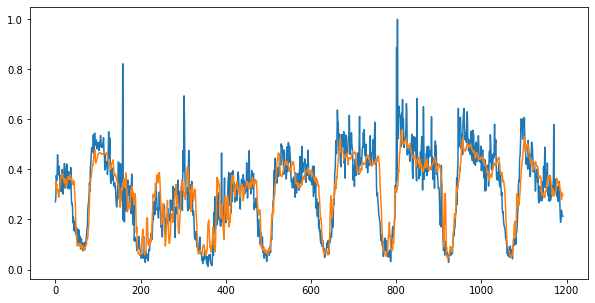

In [105]:
plt.figure(figsize=(10,5))
plt.plot(y_val_uni)
plt.plot(test_predictions_lstm_m_s)
plt.show()

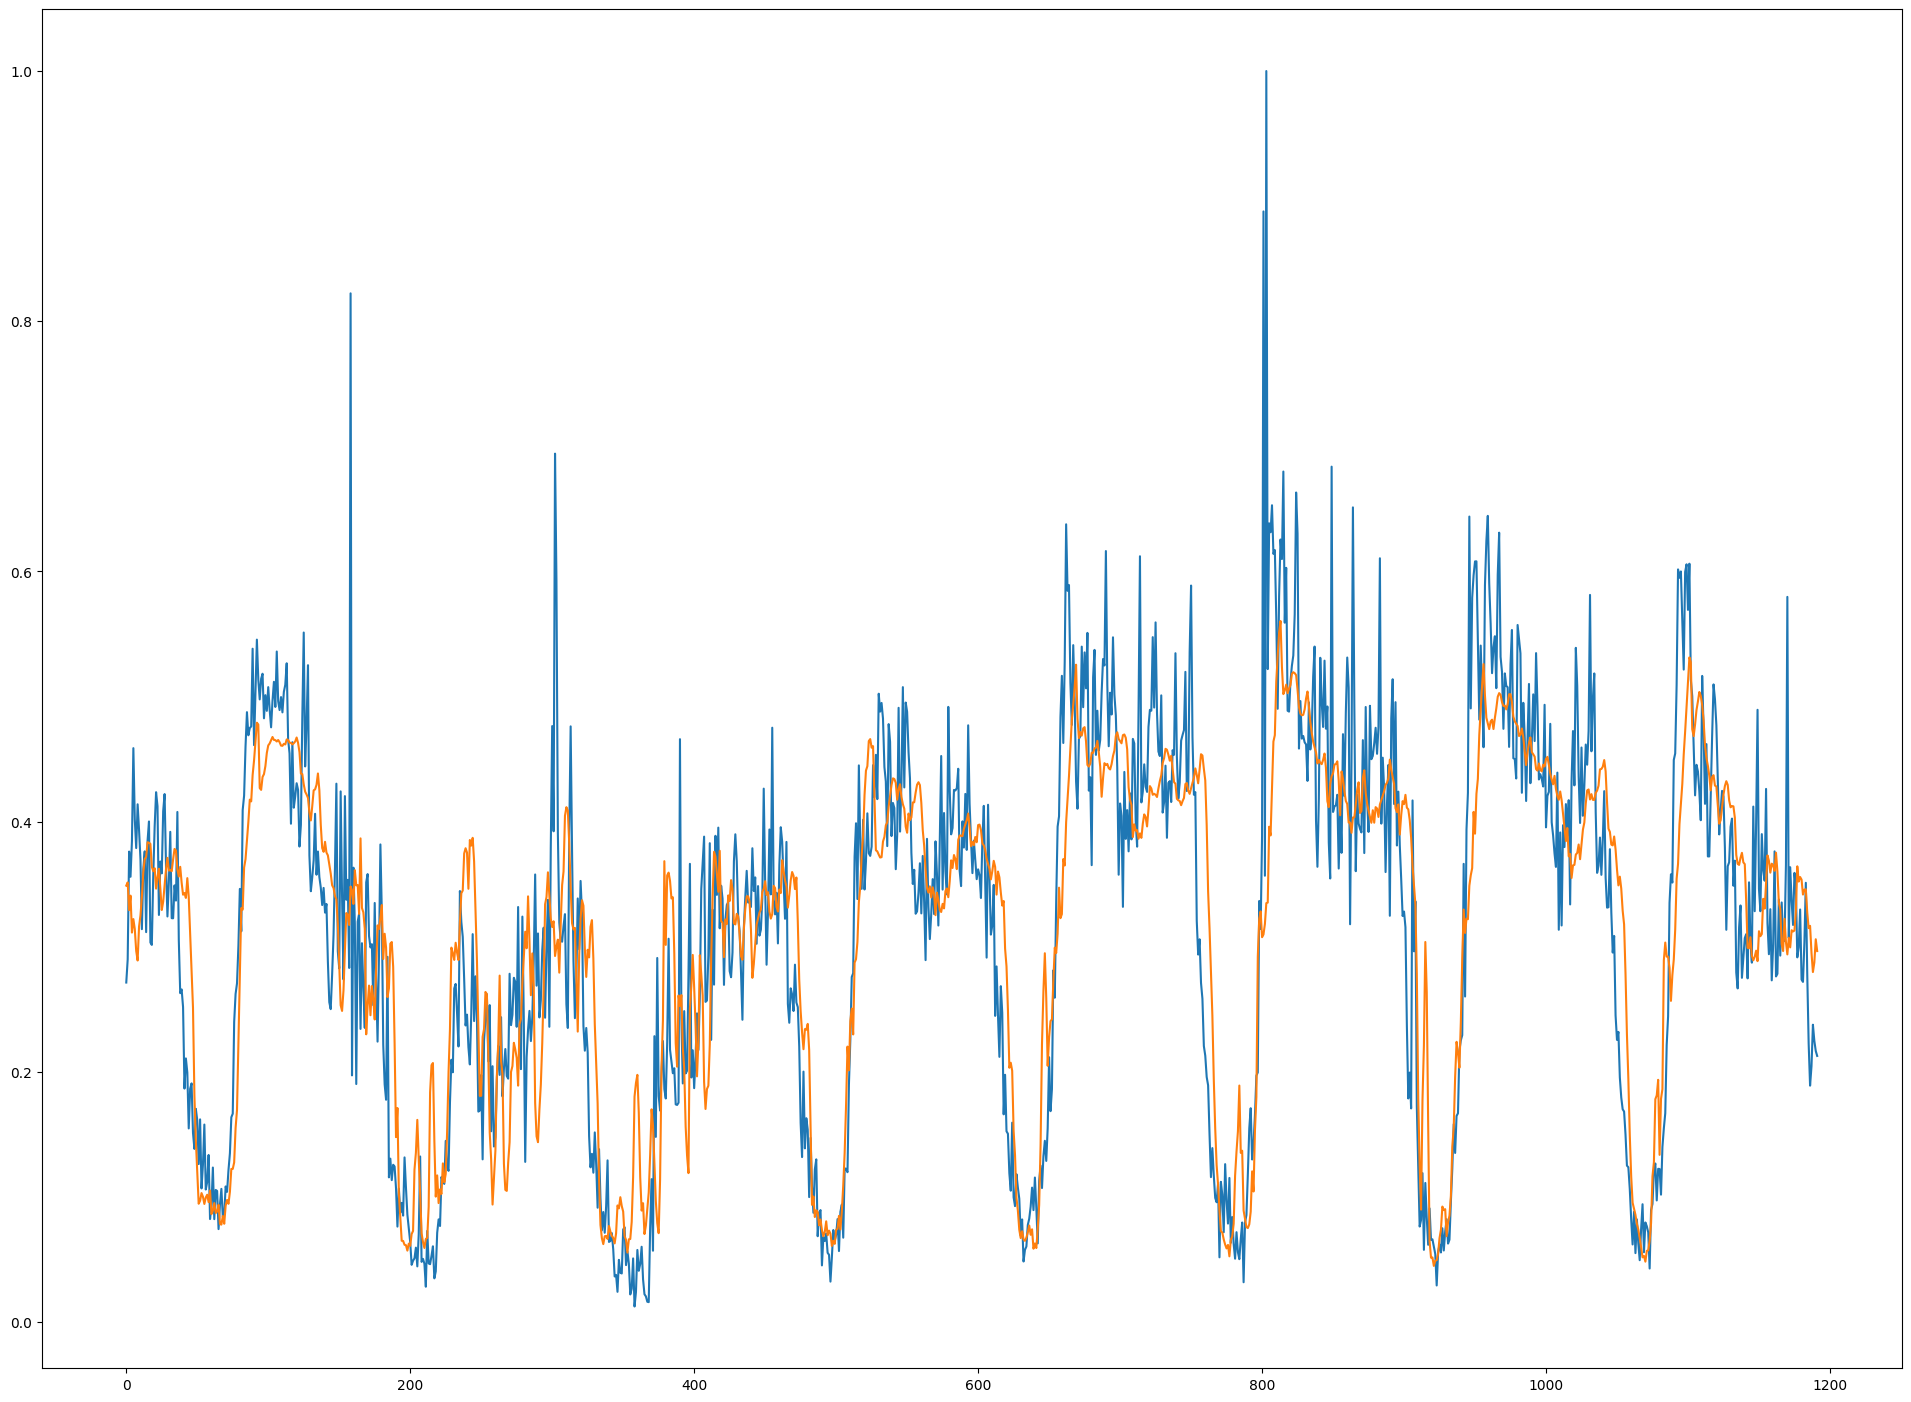

In [106]:
plt.figure(figsize=(24, 18), dpi=100) 
plt.plot(y_val_uni)
plt.plot(test_predictions_lstm_m_s)
plt.savefig('transformed_data/images/BEST-5570-12-0-6-TRPW-sep-LSTM.png',bbox_inches='tight')
plt.show()

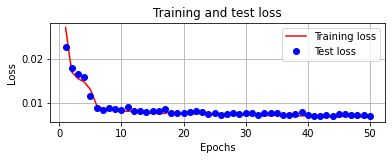

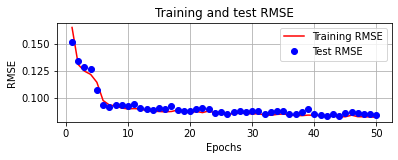

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_lstm_m_s.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
rmse_values = history_dict['root_mean_squared_error']
val_rmse_values = history_dict['val_root_mean_squared_error']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_lstm_m_s.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_lstm_m_s.history['root_mean_squared_error'], 'r', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'bo', label='Test RMSE')
plt.title('Training and test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') 
plt.legend()
plt.grid('off')
plt.savefig('transformed_data/images/BEST-5570-24-0-6-TRPW-sep-LSTM_Loss_RMSE.png',bbox_inches='tight')
plt.show()

In [108]:
print (dmse)

0.042602595


In [109]:
print (drmse)

0.083883844


# Recurrent neural network con cambio de hiperparametros con la CellId 5570 multivariate time series - GRU SEPARADO

In [110]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet']

In [111]:
multi_data5570 = dataMeteoCellId5570[features_considered]
multi_data5570.index = dataMeteoCellId5570['idx'] - 47088.0
multi_data5570.head()

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                     
0.0     9.900000              88.0            0.0       1.00  264.667864
1.0     9.916667              88.0            0.0       0.95  229.886522
2.0     9.933333              88.0            0.0       0.90  260.543188
3.0     9.950000              88.0            0.0       0.85  241.326109
4.0     9.966667              88.0            0.0       0.80  253.345193

In [112]:
len(multi_data5570)

4033

In [113]:
multi_data5570

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                        
0.0        9.900000              88.0            0.0       1.00  264.667864
1.0        9.916667              88.0            0.0       0.95  229.886522
2.0        9.933333              88.0            0.0       0.90  260.543188
3.0        9.950000              88.0            0.0       0.85  241.326109
4.0        9.966667              88.0            0.0       0.80  253.345193
...             ...               ...            ...        ...         ...
4028.0     0.900000             100.0            0.0       0.70  301.659528
4029.0     0.900000             100.0            0.0       0.70  325.776125
4030.0     0.900000             100.0            0.0       0.70  316.402061
4031.0     0.900000             100.0            0.0       0.70  310.504314
4032.0     0.900000             100.0            0.0       0.70  307.614187

[4033 rows x 5 columns]

In [114]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5570 = scaler.fit_transform(multi_data5570)

In [115]:
dataset = DataScaledMeteoCellId5570

In [116]:
dataset

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414, 0.22467967],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21657753],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21260717]])

In [117]:
len(dataset)

4033

In [118]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [119]:
dataset[:, 4]

array([0.1536089 , 0.10582741, 0.14794255, ..., 0.22467967, 0.21657753,
       0.21260717])

In [120]:
dataset[:, [0,1,2,3]]

array([[0.67333333, 0.84615385, 0.        , 0.10344828],
       [0.67444444, 0.84615385, 0.        , 0.09482759],
       [0.67555556, 0.84615385, 0.        , 0.0862069 ],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414],
       [0.07333333, 1.        , 0.        , 0.05172414],
       [0.07333333, 1.        , 0.        , 0.05172414]])

In [121]:
#univariate_past_history = 12
#univariate_future_target = 6
past_history = 12
future_target = 6
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [122]:
len(x_train_multi)

2811

In [123]:
len(x_val_multi)

1192

In [124]:
EPOCHS = [75]
BATCH_SIZE = [256]
NODOS = [64]
LAYERS = [8]
LEARNINGRATE = [0.0005]

i = 1
model5570ArrayAcc = []
model5570mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_gru_m_s = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_gru_m_s.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_gru_m_s.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_gru_m_s.add(tf.keras.layers.GRU(nodo))
                else :
                    simple_gru_m_s.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_gru_m_s.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                    simple_gru_m_s.add(tf.keras.layers.GRU(nodo))
                simple_gru_m_s.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_gru_m_s.summary()

                simple_gru_m_s.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

                history_gru_m_s = simple_gru_m_s.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)
                
                score = simple_gru_m_s.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5570ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], score[0], score[1]])
                
                test_predictions_gru_m_s = simple_gru_m_s.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions_gru_m_s).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions_gru_m_s).numpy()
                model5570mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 75batch: 256nodos: 64layer: 8
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, 12, 64)            12864     
_________________________________________________________________
gru_17 (GRU)                 (None, 12, 64)            24960     
_________________________________________________________________
gru_18 (GRU)                 (None, 12, 64)            24960     
_________________________________________________________________
gru_19 (GRU)                 (None, 12, 64)            24960     
_________________________________________________________________
gru_20 (GRU)                 (None, 12, 64)            24960     
_________________________________________________________________
gru_21 (GRU)                 (None, 12, 64)            24960     
_________________________________________________________________
gru_22 (GRU)    

In [125]:
test_predictions_gru_m_s

array([[0.34260708],
       [0.3449968 ],
       [0.31891322],
       ...,
       [0.2844271 ],
       [0.29576916],
       [0.28670415]], dtype=float32)

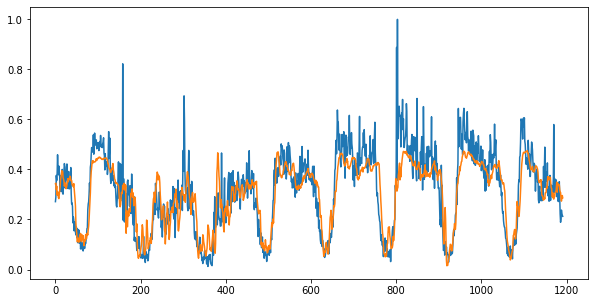

In [126]:
plt.figure(figsize=(10,5))
plt.plot(y_val_uni)
plt.plot(test_predictions_gru_m_s)
plt.show()

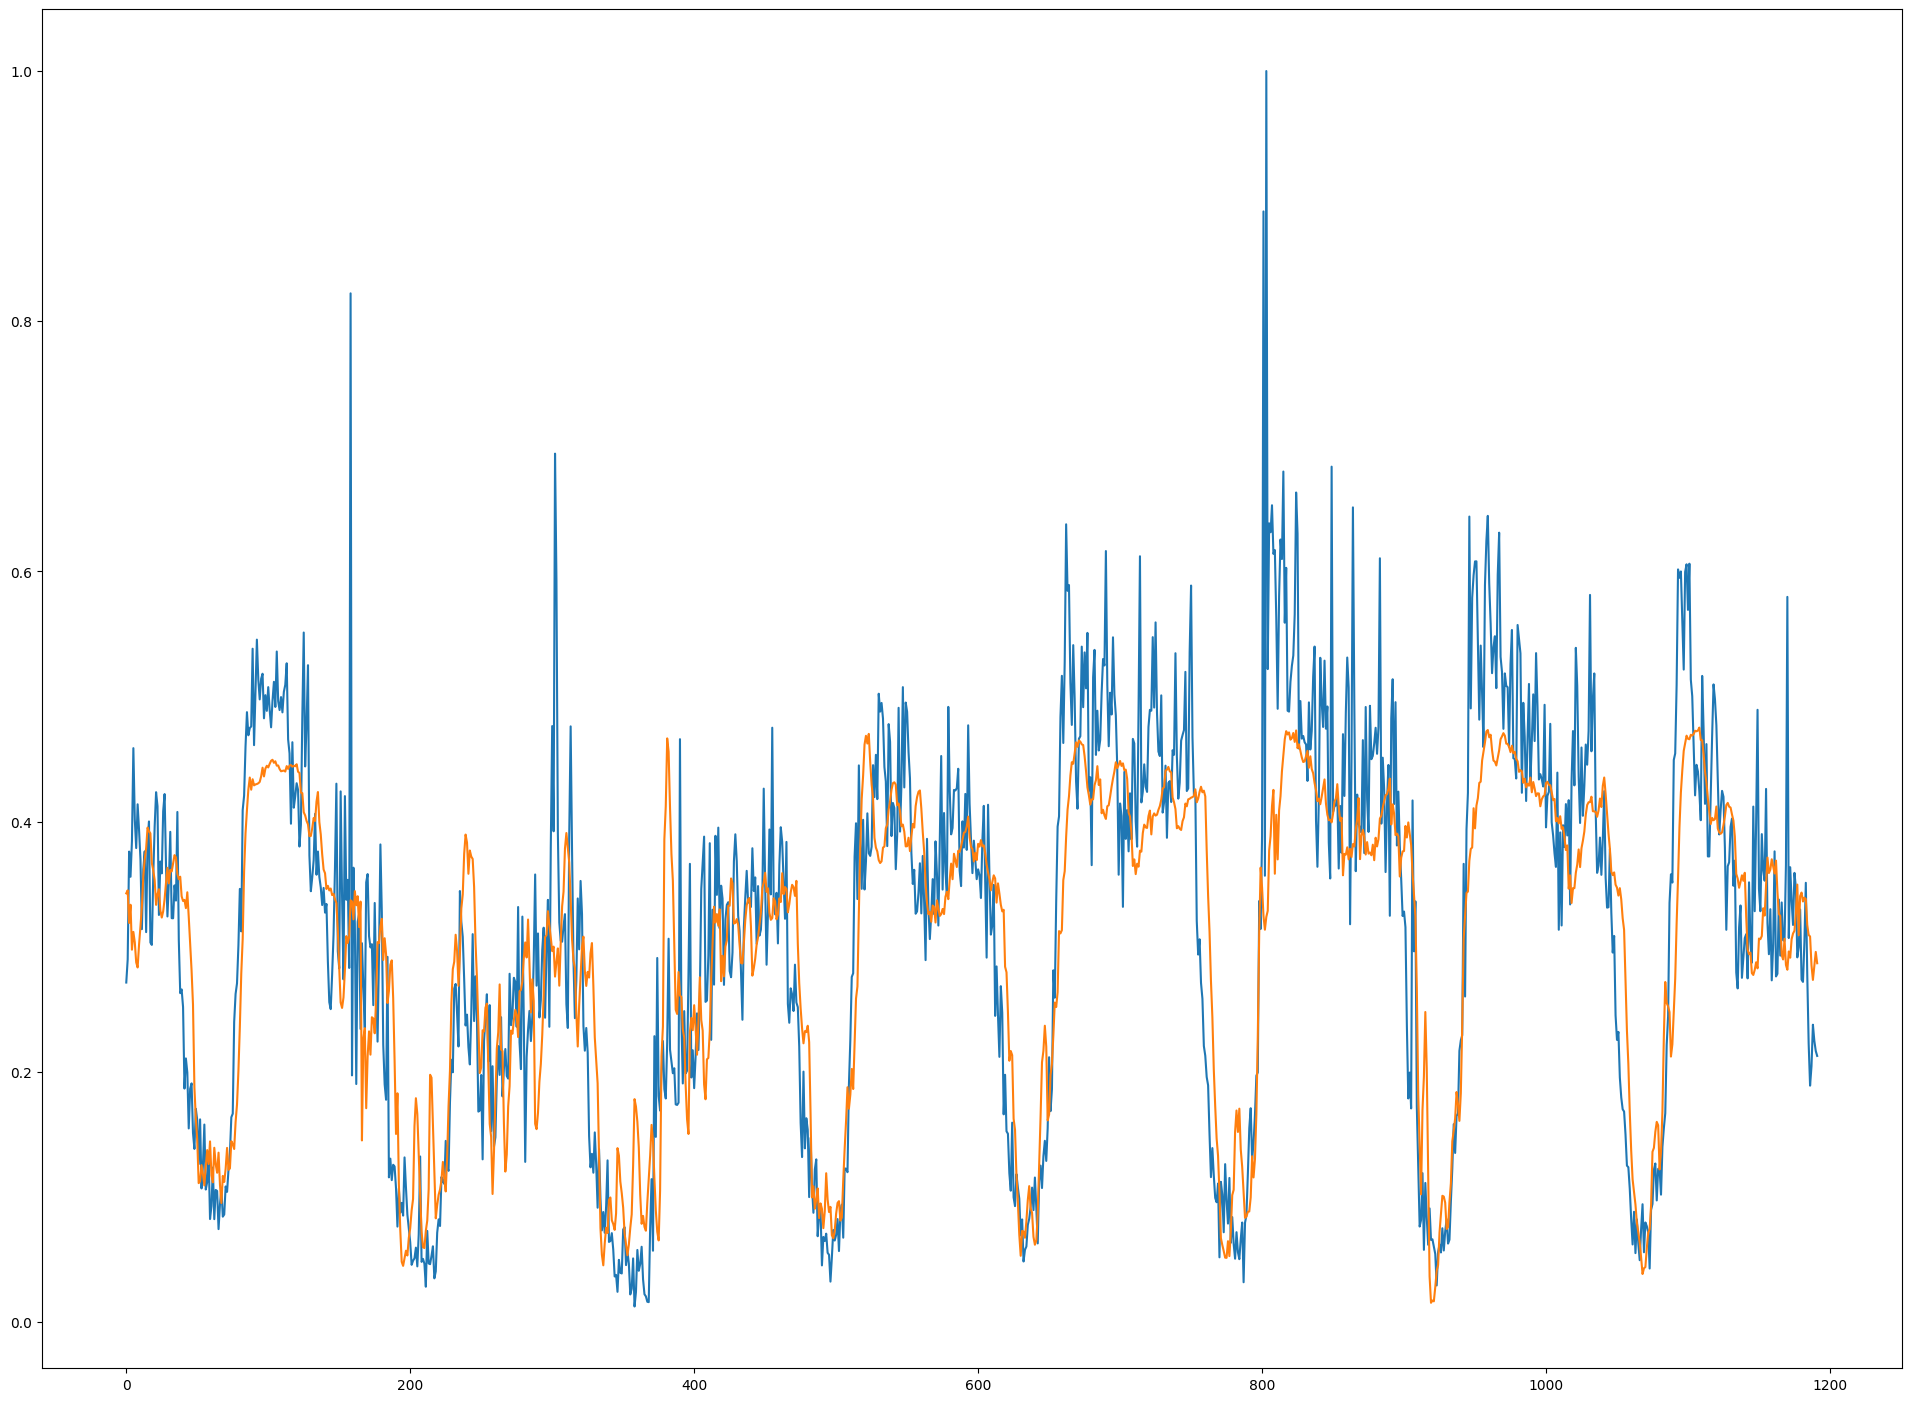

In [127]:
plt.figure(figsize=(24, 18), dpi=100) 
plt.plot(y_val_uni)
plt.plot(test_predictions_gru_m_s)
plt.savefig('transformed_data/images/BEST-5570-12-0-6-TRPW-sep-GRU.png',bbox_inches='tight')
plt.show()

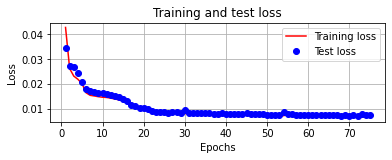

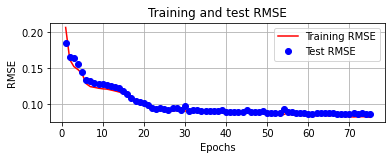

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_gru_m_s.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
rmse_values = history_dict['root_mean_squared_error']
val_rmse_values = history_dict['val_root_mean_squared_error']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_gru_m_s.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_gru_m_s.history['root_mean_squared_error'], 'r', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'bo', label='Test RMSE')
plt.title('Training and test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') 
plt.legend()
plt.grid('off')
plt.savefig('transformed_data/images/BEST-5570-12-0-6-TRPW-sep-GRU_Loss_RMSE.png',bbox_inches='tight')
plt.show()

In [129]:
print (dmse)

0.04023935


In [130]:
print (drmse)

0.08712959


# Conjunto LSTM y GRU

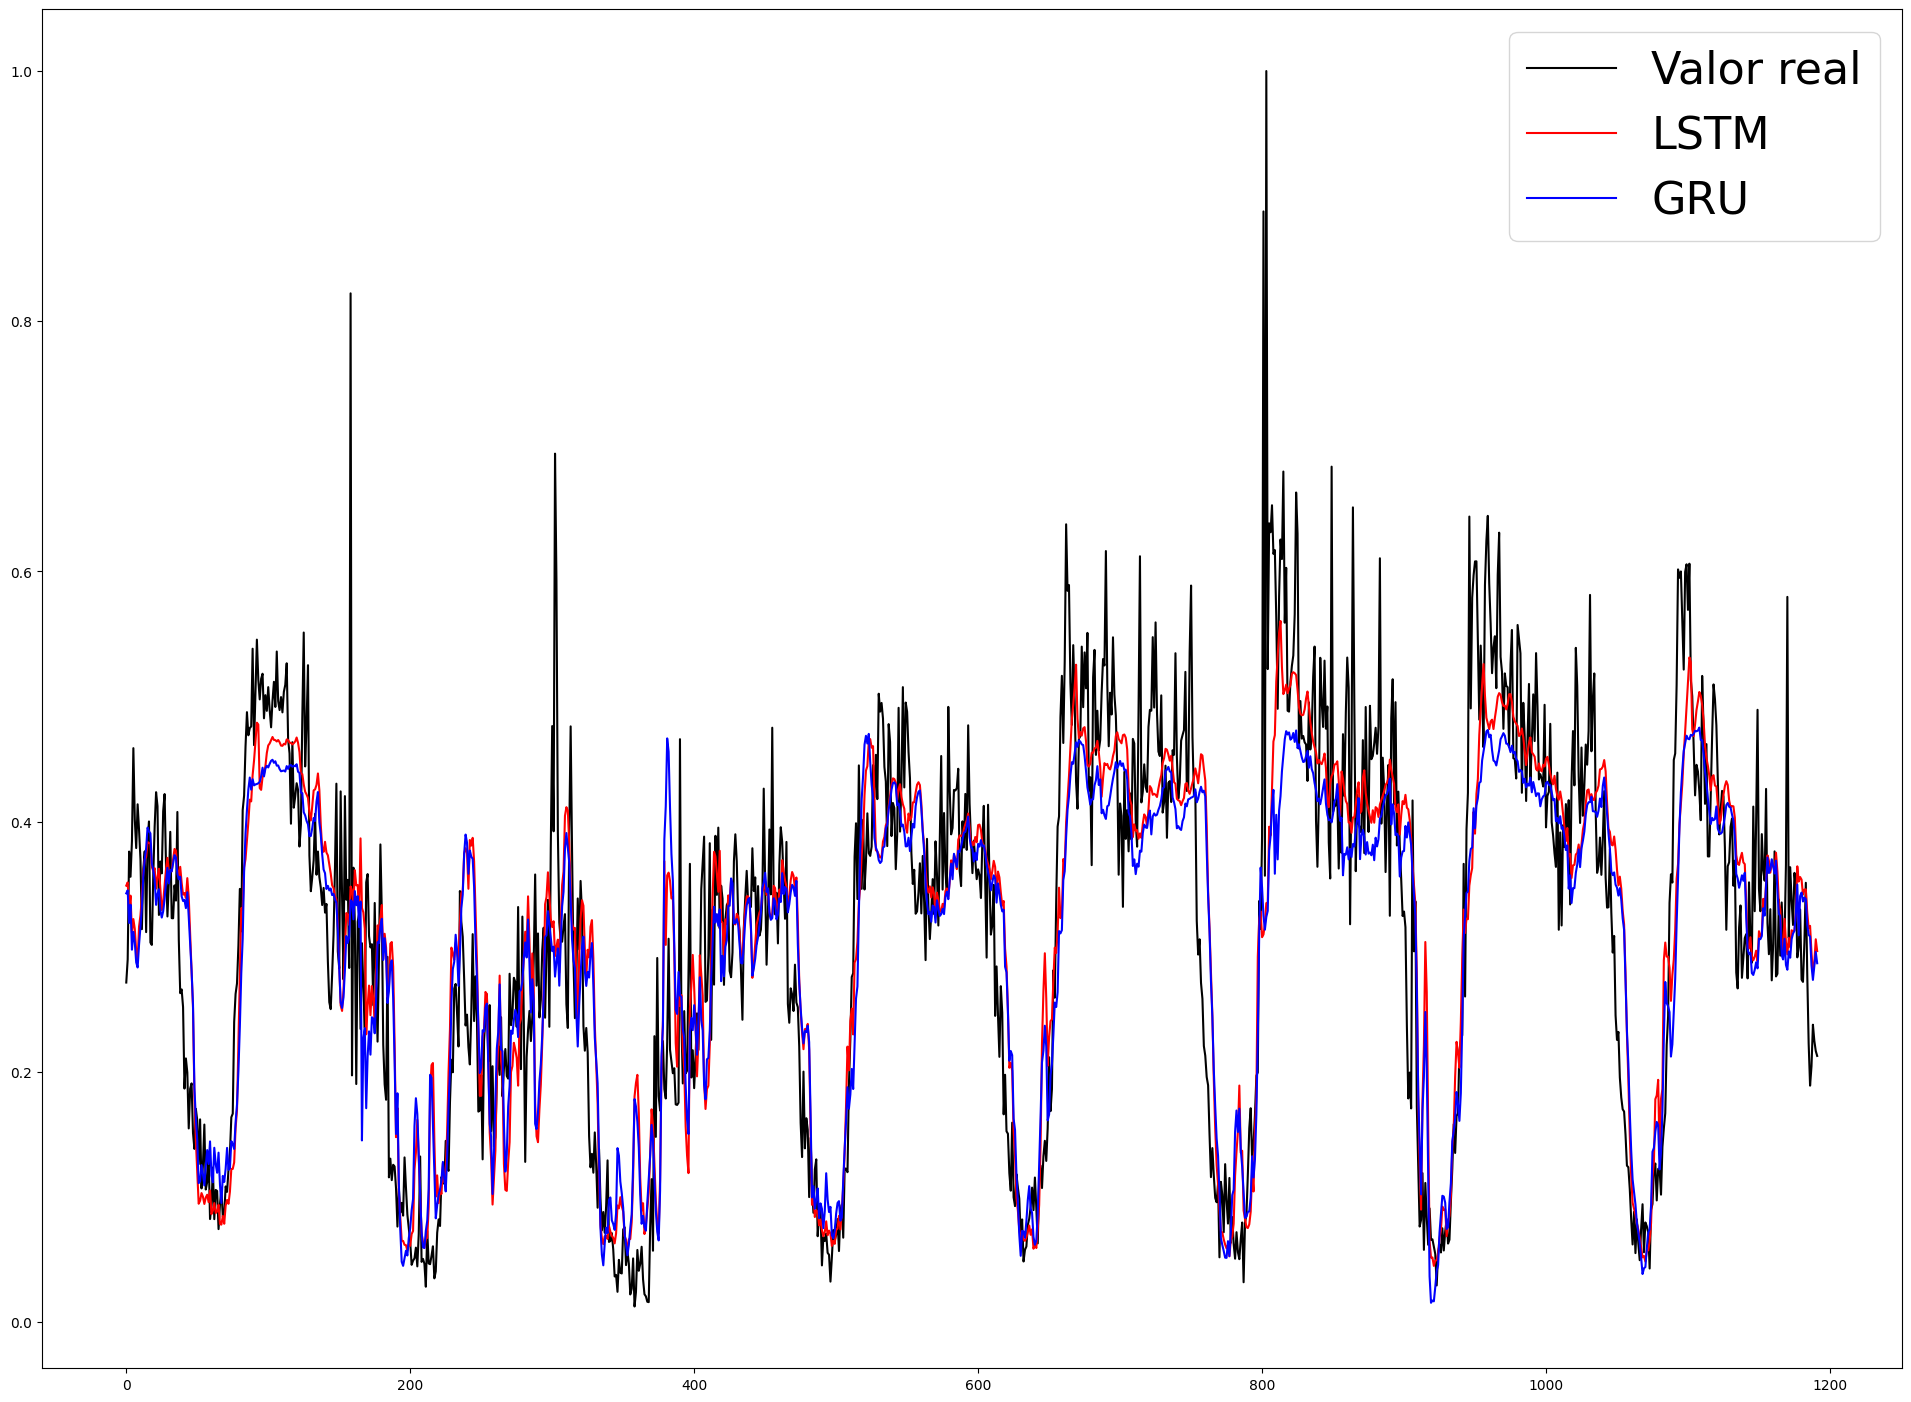

In [131]:
plt.figure(figsize=(24, 18), dpi=100) 
real, = plt.plot(y_val_uni, color='k')
glstm, = plt.plot(test_predictions_lstm_m_s, color='r')
ggru, = plt.plot(test_predictions_gru_m_s, color='b')

plt.legend([real, glstm, ggru], ["Valor real", "LSTM", "GRU"], prop={'size': 32})

plt.savefig('transformed_data/images/5570-12-0-6-TRPW-sep_LSTM_GRU_COMB.png',bbox_inches='tight')
plt.show()

# Comparación LSTM uni, multi TRPW y multi TRPW sep

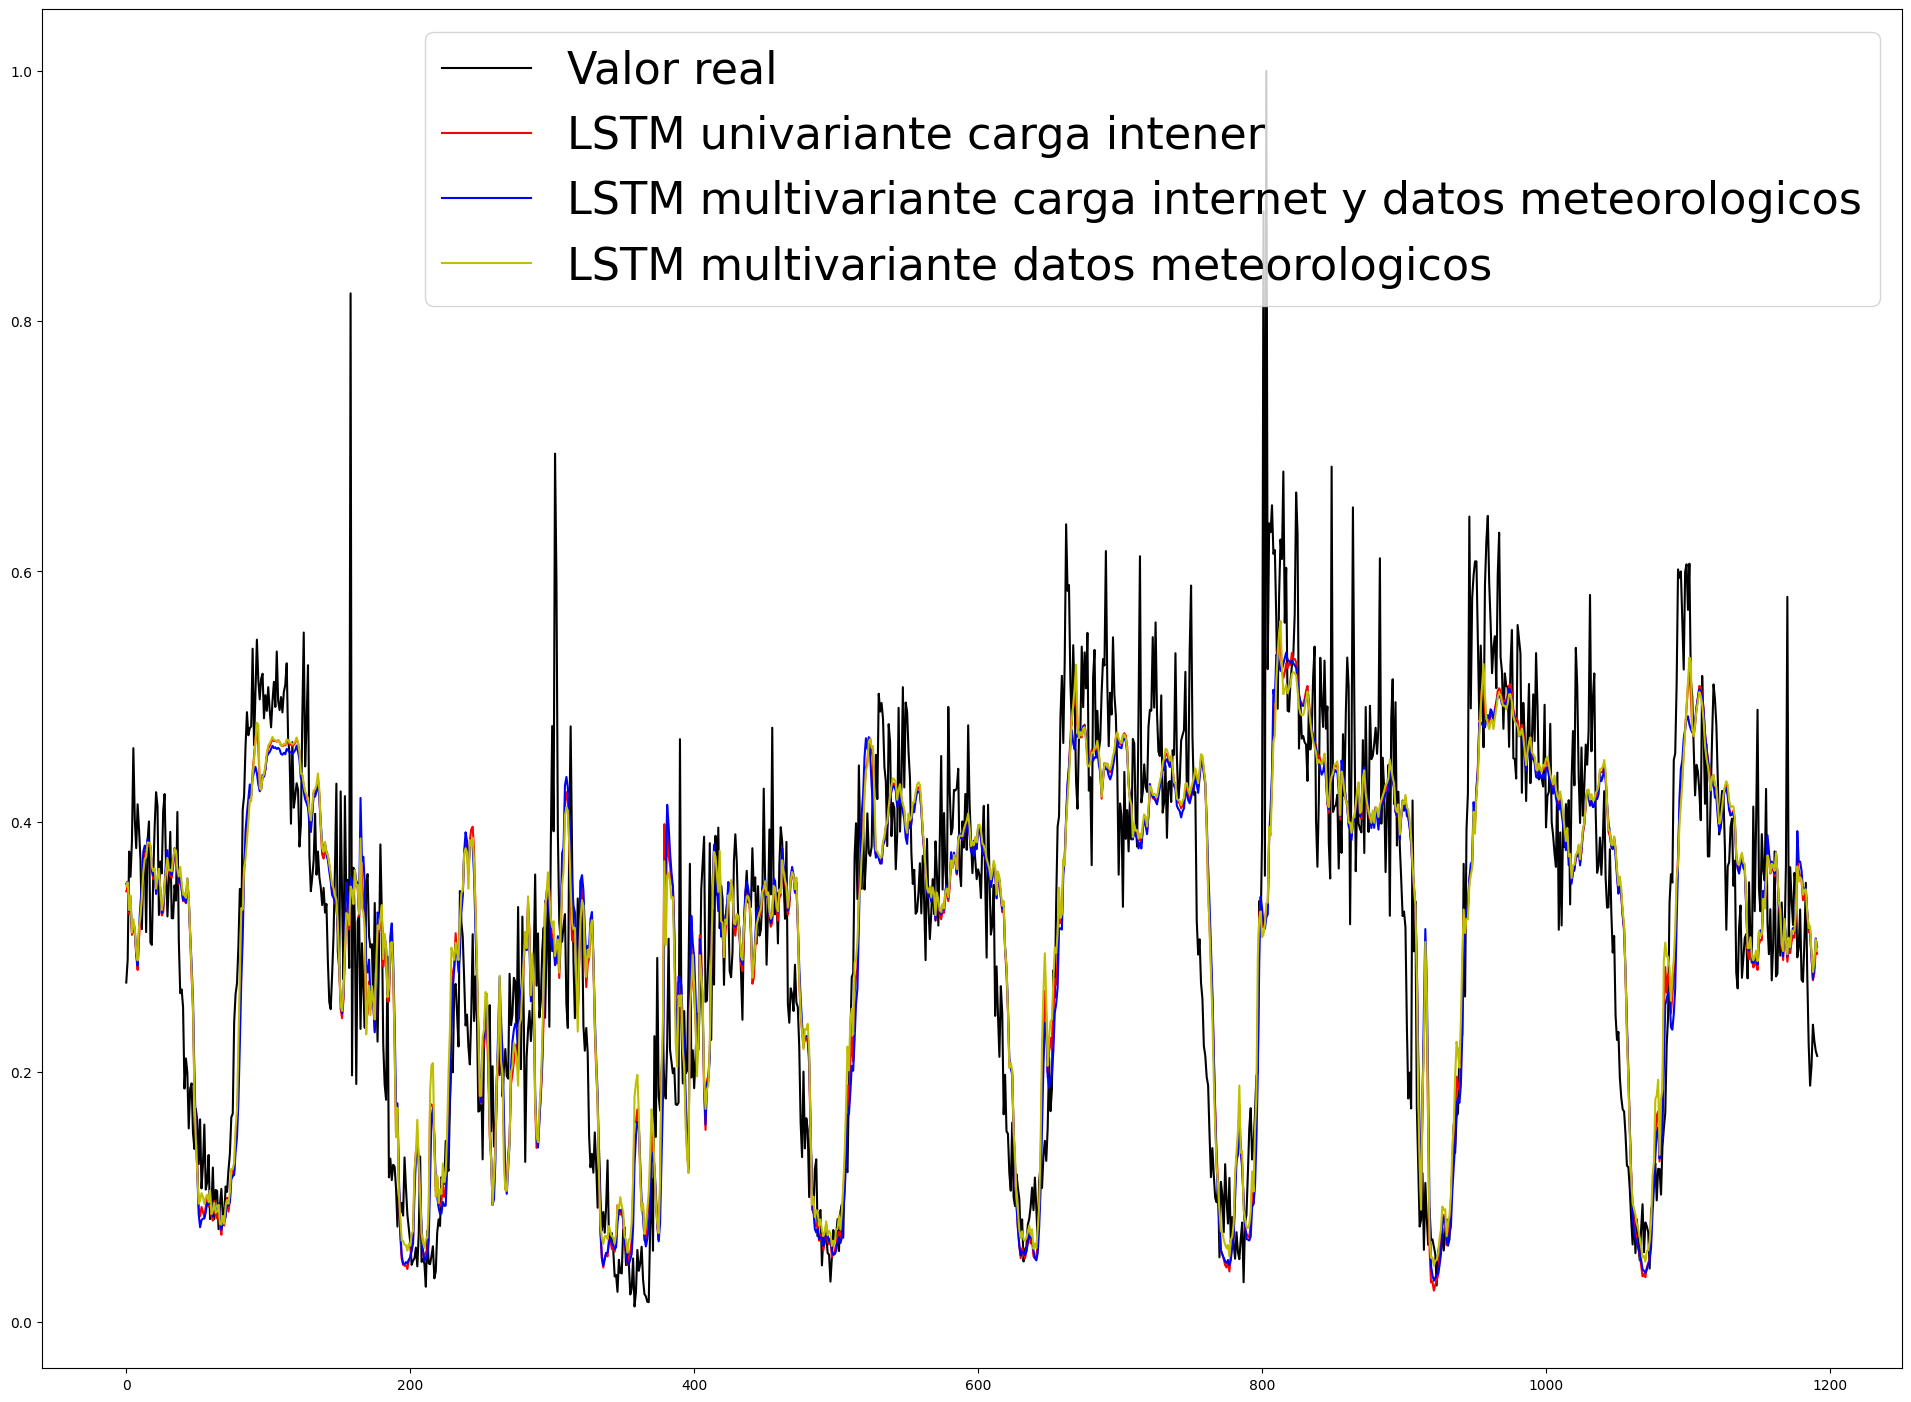

In [156]:
plt.figure(figsize=(24, 18), dpi=100) 
real, = plt.plot(y_val_uni, color='k')
glstm_s, = plt.plot(test_predictions_lstm_s, color='r')
glstm_m, = plt.plot(test_predictions_lstm_m, color='b')
glstm_m_s, = plt.plot(test_predictions_lstm_m_s, color='y')

plt.legend([real, glstm_s, glstm_m, glstm_m_s], ["Valor real", "LSTM univariante carga intener", "LSTM multivariante carga internet y datos meteorologicos", "LSTM multivariante datos meteorologicos"], prop={'size': 32})

plt.savefig('transformed_data/images/5570-12-0-6_LSTM_COMP.png',bbox_inches='tight')
plt.show()

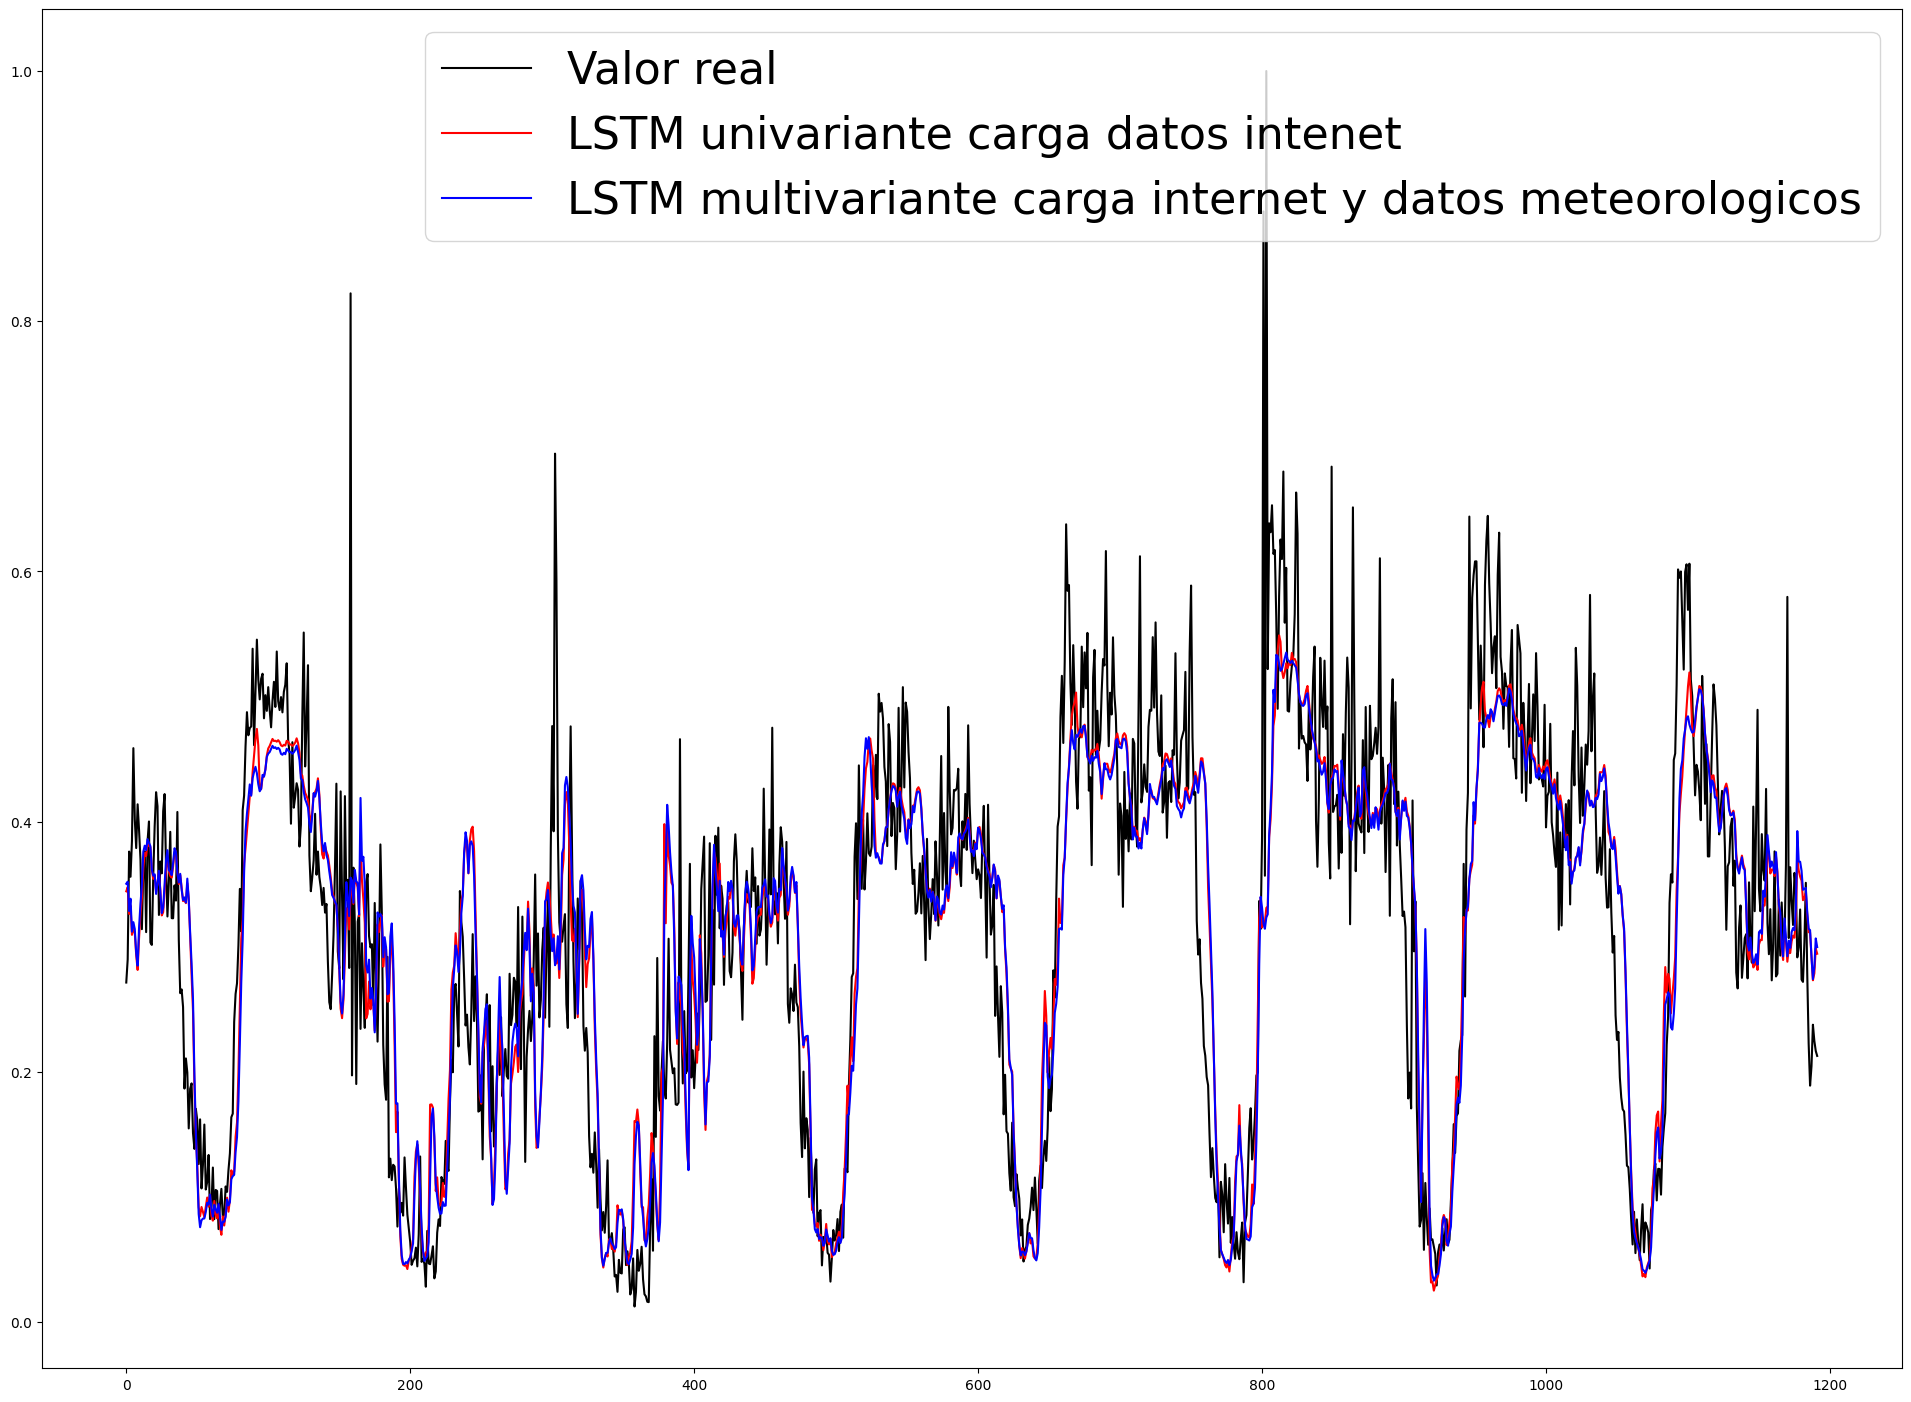

In [155]:
plt.figure(figsize=(24, 18), dpi=100) 
real, = plt.plot(y_val_uni, color='k')
glstm_s, = plt.plot(test_predictions_lstm_s, color='r')
glstm_m, = plt.plot(test_predictions_lstm_m, color='b')

plt.legend([real, glstm_s, glstm_m], ["Valor real", "LSTM univariante carga datos intenet", "LSTM multivariante carga internet y datos meteorologicos"], prop={'size': 32})

plt.savefig('transformed_data/images/5570-12-0-6_LSTM_COMP_BEST_LESSBEST.png',bbox_inches='tight')
plt.show()

# Comparación GRU uni, multi TRPW y multi TRPW sep

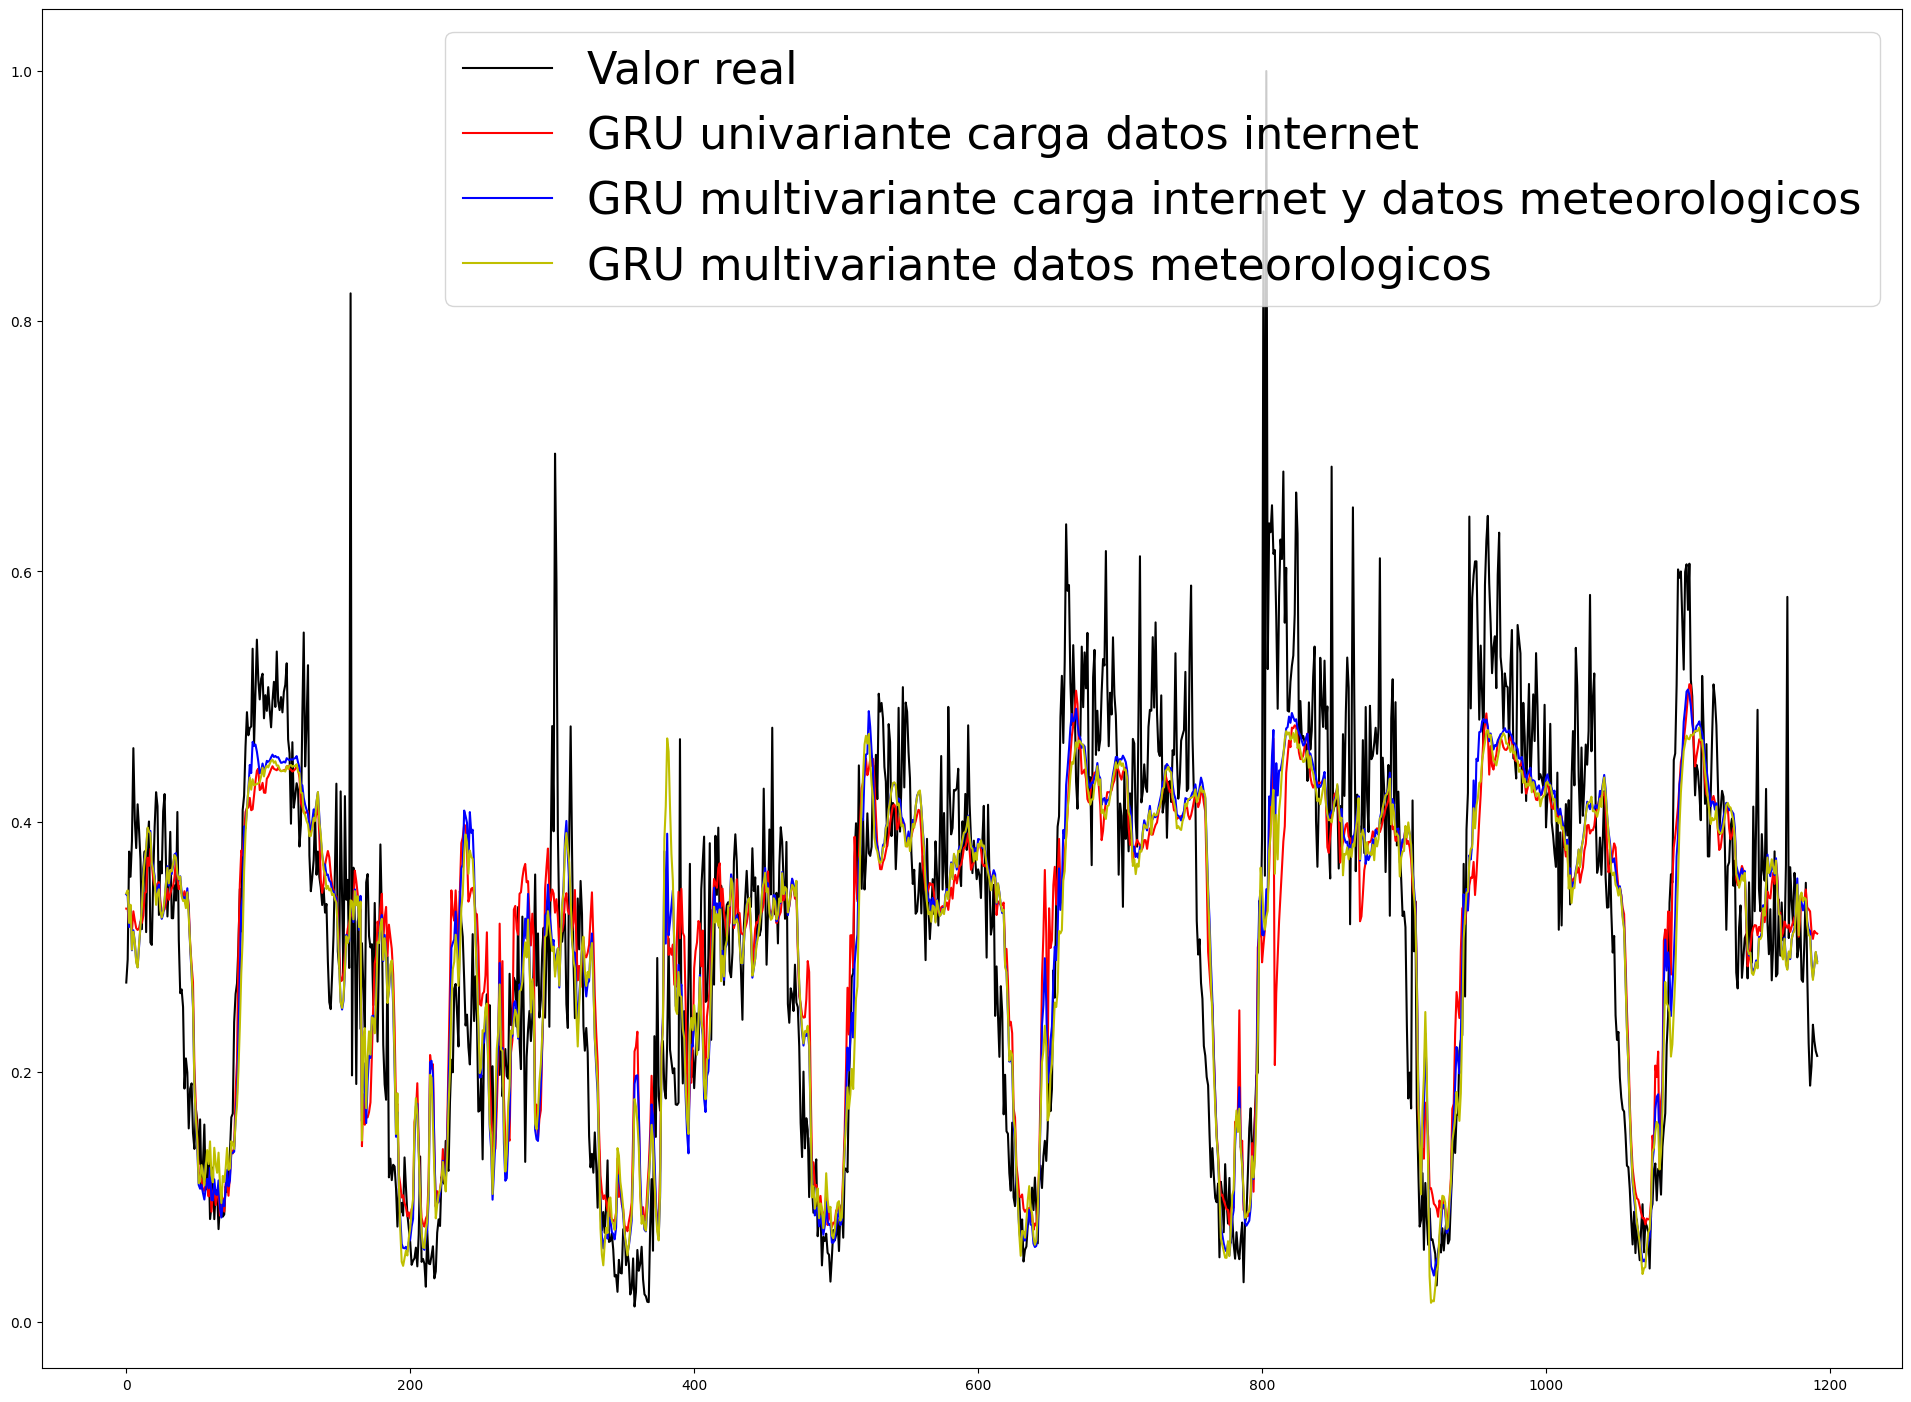

In [154]:
plt.figure(figsize=(24, 18), dpi=100) 
real, = plt.plot(y_val_uni, color='k')
ggru_s, = plt.plot(test_predictions_gru_s, color='r')
ggru_m, = plt.plot(test_predictions_gru_m, color='b')
ggru_m_s, = plt.plot(test_predictions_gru_m_s, color='y')

plt.legend([real, ggru_s, ggru_m, ggru_m_s], ["Valor real", "GRU univariante carga datos internet", "GRU multivariante carga internet y datos meteorologicos", "GRU multivariante datos meteorologicos"], prop={'size': 32})

plt.savefig('transformed_data/images/5570-12-0-6_GRU_COMP.png',bbox_inches='tight')
plt.show()

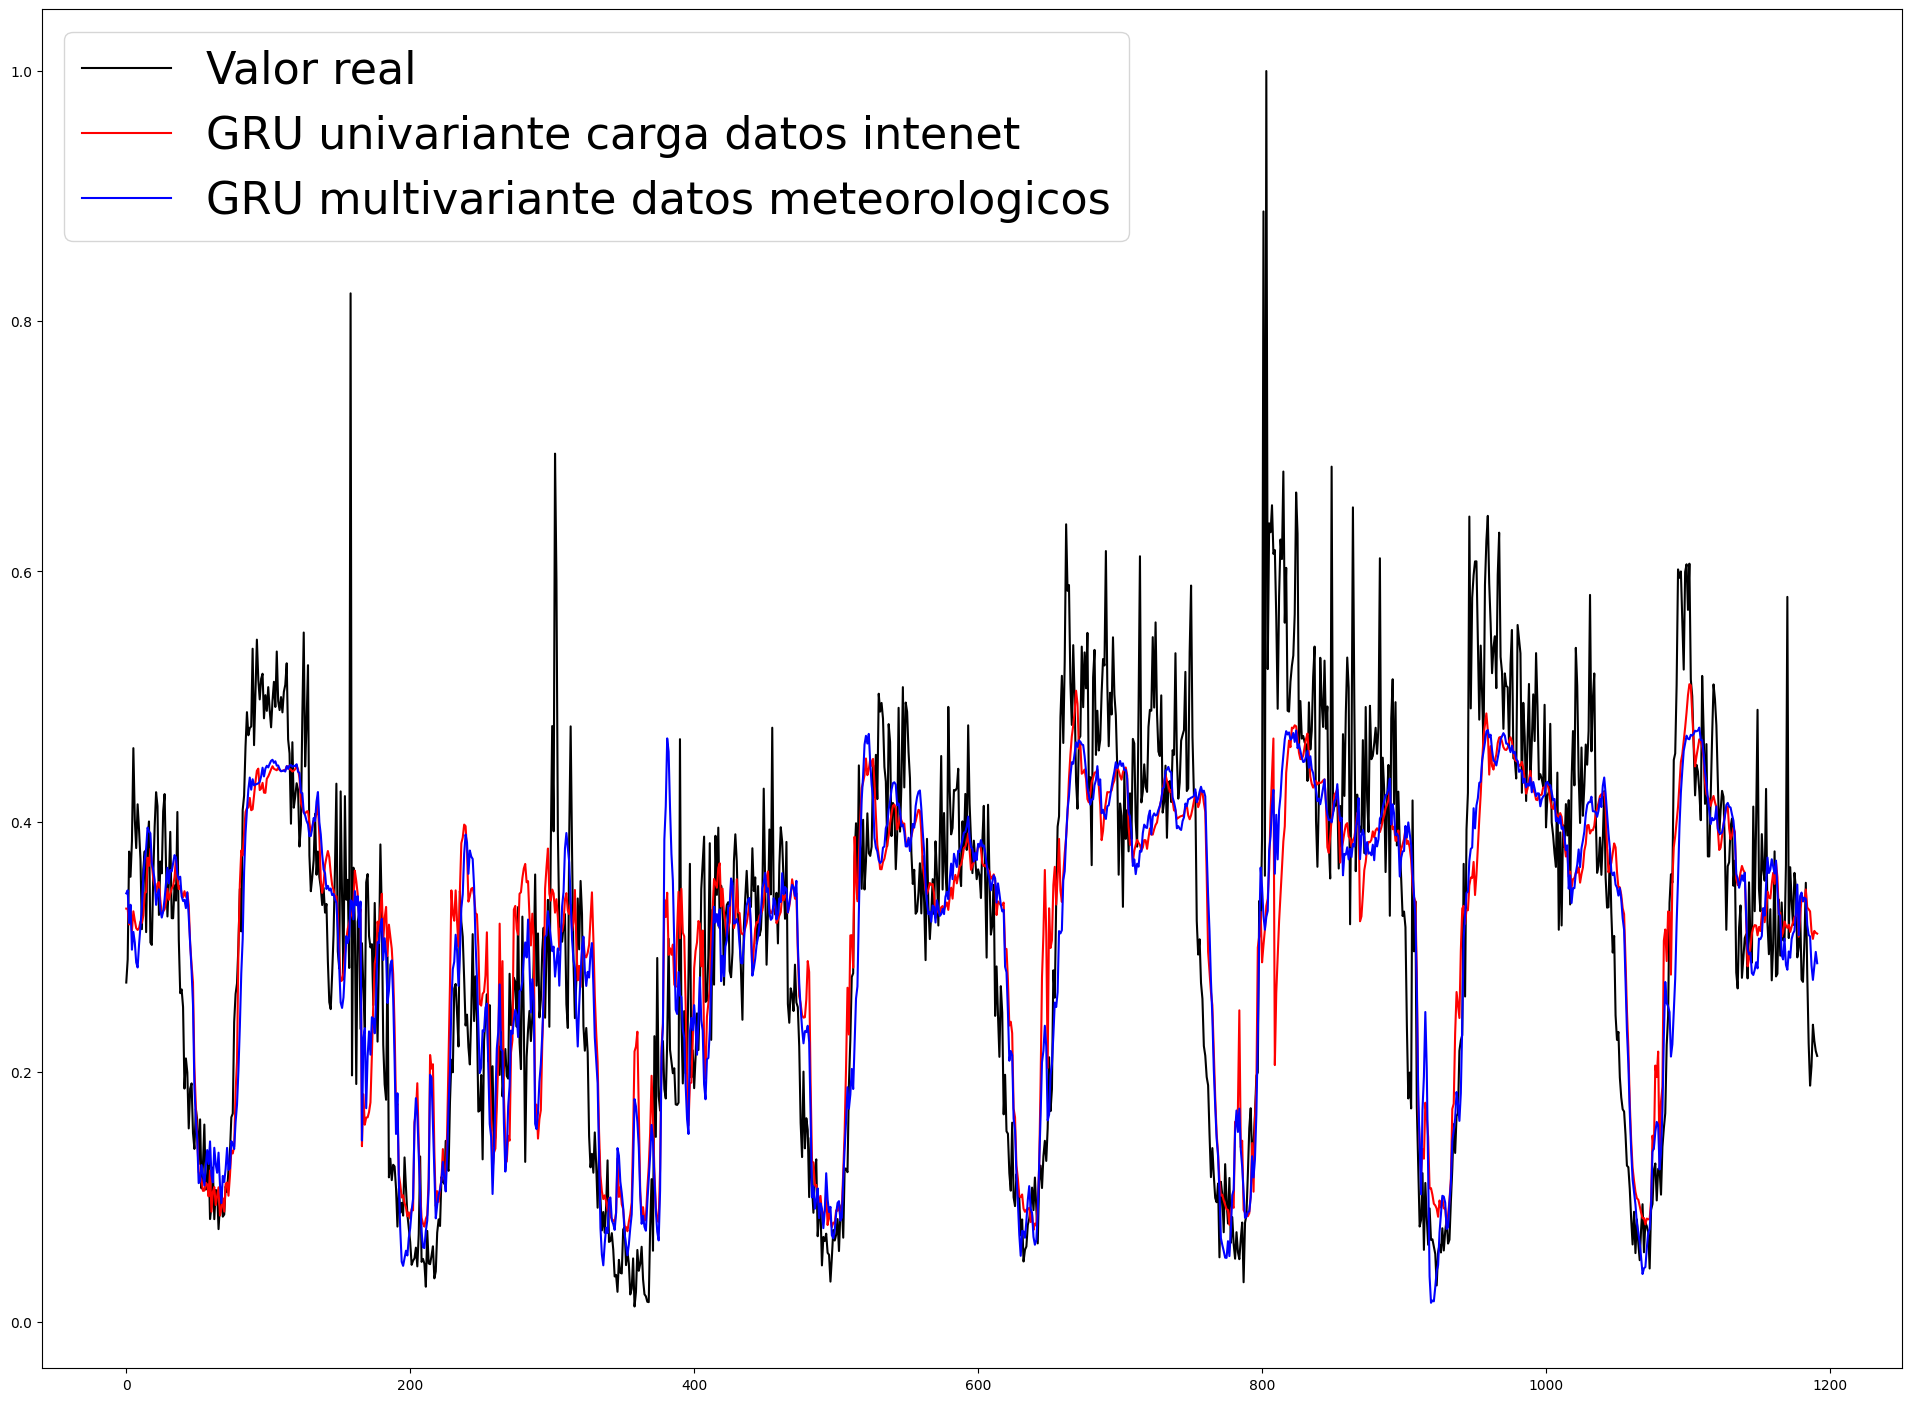

In [153]:
plt.figure(figsize=(24, 18), dpi=100) 
real, = plt.plot(y_val_uni, color='k')
ggru_s, = plt.plot(test_predictions_gru_s, color='r')
ggru_m_s, = plt.plot(test_predictions_gru_m_s, color='b')

plt.legend([real, ggru_s, ggru_m_s], ["Valor real", "GRU univariante carga datos intenet", "GRU multivariante datos meteorologicos"], prop={'size': 32})

plt.savefig('transformed_data/images/5570-12-0-6_GRU_COMP_BEST_LESSBEST.png',bbox_inches='tight')
plt.show()

# Codigo para recuperarse de problemas con GPU

# gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

In [132]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

IndexError: list index out of range